In [6]:
import os, glob, sys
from pathlib import Path
import pandas as pd
import numpy as np
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

In [11]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be:
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm.

     Returns the smoothed velocity components
    """

    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
    else:
        sys.exit('invalid kernel')

    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    if fov is None:
        vx1f, vx2f, vy1f, vy2f = vx1, vx2, vy1, vy2
    else:
        vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

ker = 'gaussian'

In [162]:
columns = ['index', 'kernel', 'rs', 'intsteps', 'ballspacing', 'am', 'dp', 'sigma_factor', 'fourier_radius', 'corr', 'corr_top', 'corr_bot', 'RMSE_cal_vx_top', 'MAE_cal_vx_top', 'MAE_cal_vx_bot', 'MAE_cal_vx', 'MAPE', 'MAE_discrep', 'MAPD', 'p_top_0', 'p_bot_0']
caldf = pd.read_csv(Path(os.environ['DATA'],'sanity_check/stein_series/calibration3/correlation_dataframe_boxcar_gaussian.csv'), usecols=columns)
caldf = caldf[caldf['kernel'] == 'gaussian']
caldf = caldf.set_index('index').reset_index()
caldf.drop(['kernel', 'rs'], axis=1, inplace=True)
caldf.head()

index  intsteps  ballspacing   am   dp  sigma_factor  fourier_radius  \
0      0         3            1  0.3  0.1           1.0               0   
1      1         3            1  0.3  0.1           1.0               1   
2      2         3            1  0.3  0.1           1.0               2   
3      3         3            1  0.3  0.1           1.0               3   
4      4         3            1  0.3  0.1           1.0               4   

       corr  corr_top  corr_bot  MAE_cal_vx  MAE_cal_vx_top  MAE_cal_vx_bot  \
0  0.922980  0.912834  0.896699  145.405131      154.790349      168.972783   
1  0.965759  0.960055  0.954099  100.316700      108.974928      114.074341   
2  0.965670  0.959237  0.954984  101.410126      108.830651      112.436553   
3  0.964313  0.958023  0.953026  102.538378      111.200682      118.320086   
4  0.964446  0.958044  0.953389  100.830462      108.998298      115.488298   

   RMSE_cal_vx_top  MAE_discrep       MAPE       MAPD   p_top_0   p_bot_0  
0       195.868626    96.658772  20.839322  15.471865  5.901525  6.684215  
1       138.843269    67.309539  15.372926  11.271482  6.495159  8.560860  
2       138.422508    66.558813  15.871259  10.689293  6.269682  8.158298  
3       139.852557    67.686284  15.980173  11.002996  5.947756  7.597795  
4       138.746032    67.989535  15.995259  11.037428  5.612743  6.973218

In [163]:
caldf = caldf.query('ballspacing == 1')
caldf.head()

index  intsteps  ballspacing   am   dp  sigma_factor  fourier_radius  \
0      0         3            1  0.3  0.1           1.0               0   
1      1         3            1  0.3  0.1           1.0               1   
2      2         3            1  0.3  0.1           1.0               2   
3      3         3            1  0.3  0.1           1.0               3   
4      4         3            1  0.3  0.1           1.0               4   

       corr  corr_top  corr_bot  MAE_cal_vx  MAE_cal_vx_top  MAE_cal_vx_bot  \
0  0.922980  0.912834  0.896699  145.405131      154.790349      168.972783   
1  0.965759  0.960055  0.954099  100.316700      108.974928      114.074341   
2  0.965670  0.959237  0.954984  101.410126      108.830651      112.436553   
3  0.964313  0.958023  0.953026  102.538378      111.200682      118.320086   
4  0.964446  0.958044  0.953389  100.830462      108.998298      115.488298   

   RMSE_cal_vx_top  MAE_discrep       MAPE       MAPD   p_top_0   p_bot_0  
0       195.868626    96.658772  20.839322  15.471865  5.901525  6.684215  
1       138.843269    67.309539  15.372926  11.271482  6.495159  8.560860  
2       138.422508    66.558813  15.871259  10.689293  6.269682  8.158298  
3       139.852557    67.686284  15.980173  11.002996  5.947756  7.597795  
4       138.746032    67.989535  15.995259  11.037428  5.612743  6.973218

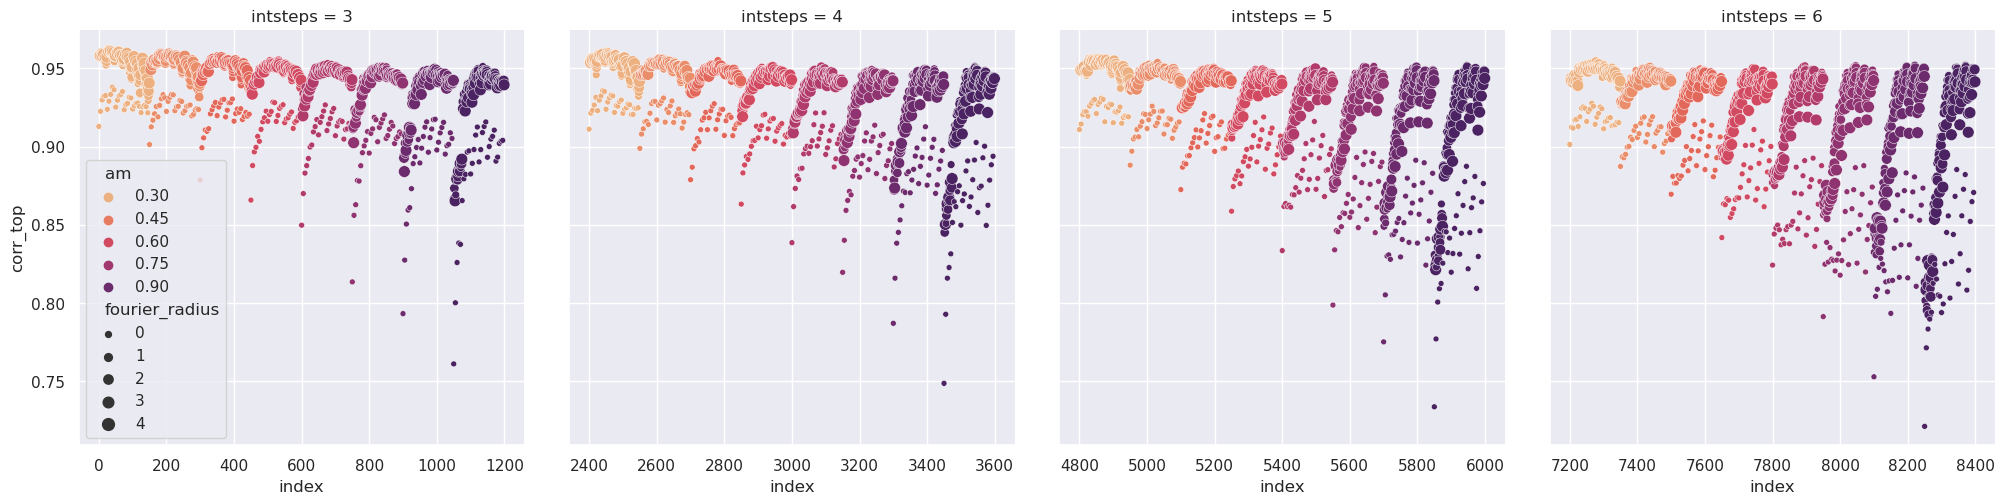

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf,
    x='index',
    y='corr_top',
    col='intsteps',
    size='fourier_radius',
    hue = 'am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':False}
)
xspan = 2400
xgroups = [xspan, 2*xspan, 3*xspan]
for i, idx in enumerate(xgroups):
    ax = g.facet_axis(0, i)
    # ax.set_ylim([0.8, 0.97])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

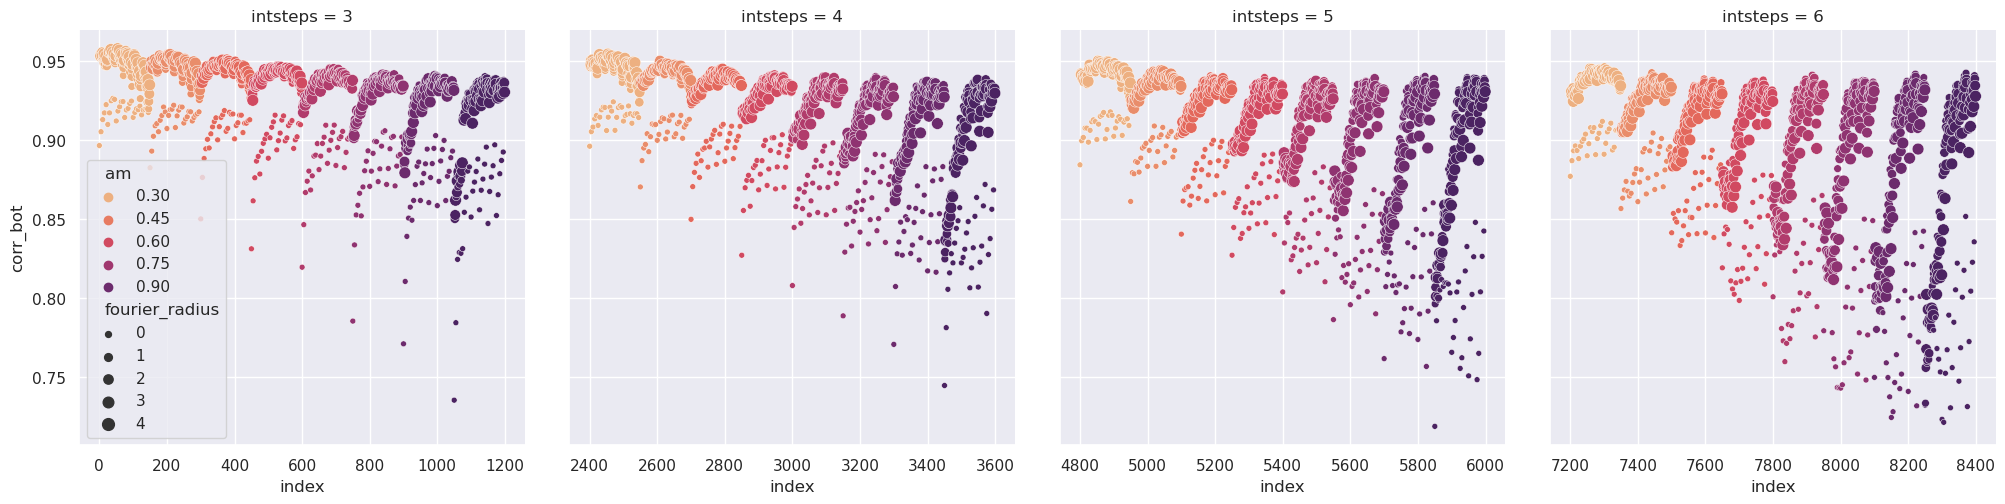

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf,
    x='index',
    y='corr_bot',
    col='intsteps',
    size='fourier_radius',
    hue = 'am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':False}
)
xspan = 2400
xgroups = [xspan, 2*xspan, 3*xspan]
for i, idx in enumerate(xgroups):
    ax = g.facet_axis(0, i)
    # ax.set_ylim([0.8, 0.97])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

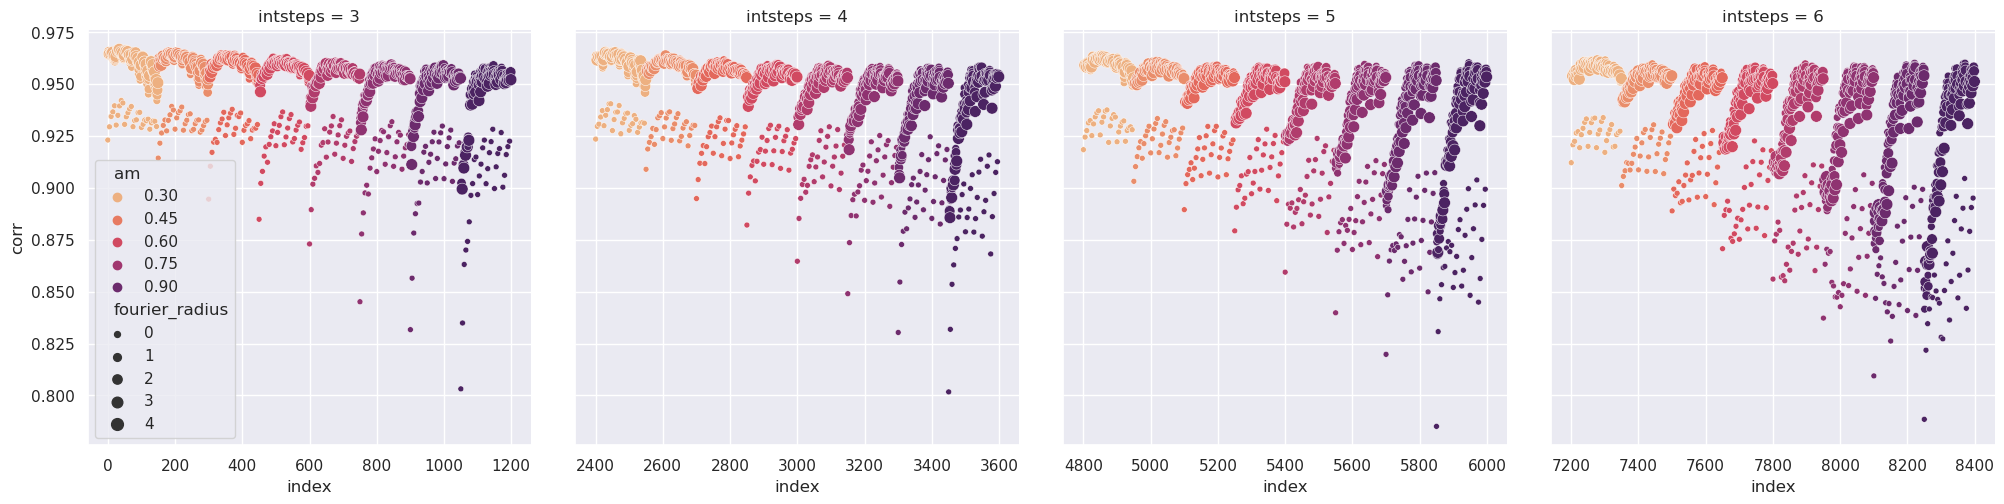

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf,
    x='index',
    y='corr',
    col='intsteps',
    size='fourier_radius',
    hue = 'am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':False}
)
xspan = 2400
xgroups = [xspan, 2*xspan, 3*xspan]
for i, idx in enumerate(xgroups):
    ax = g.facet_axis(0, i)
    # ax.set_ylim([0.8, 0.97])
    
plt.subplots_adjust(wspace=0.1)
plt.show()

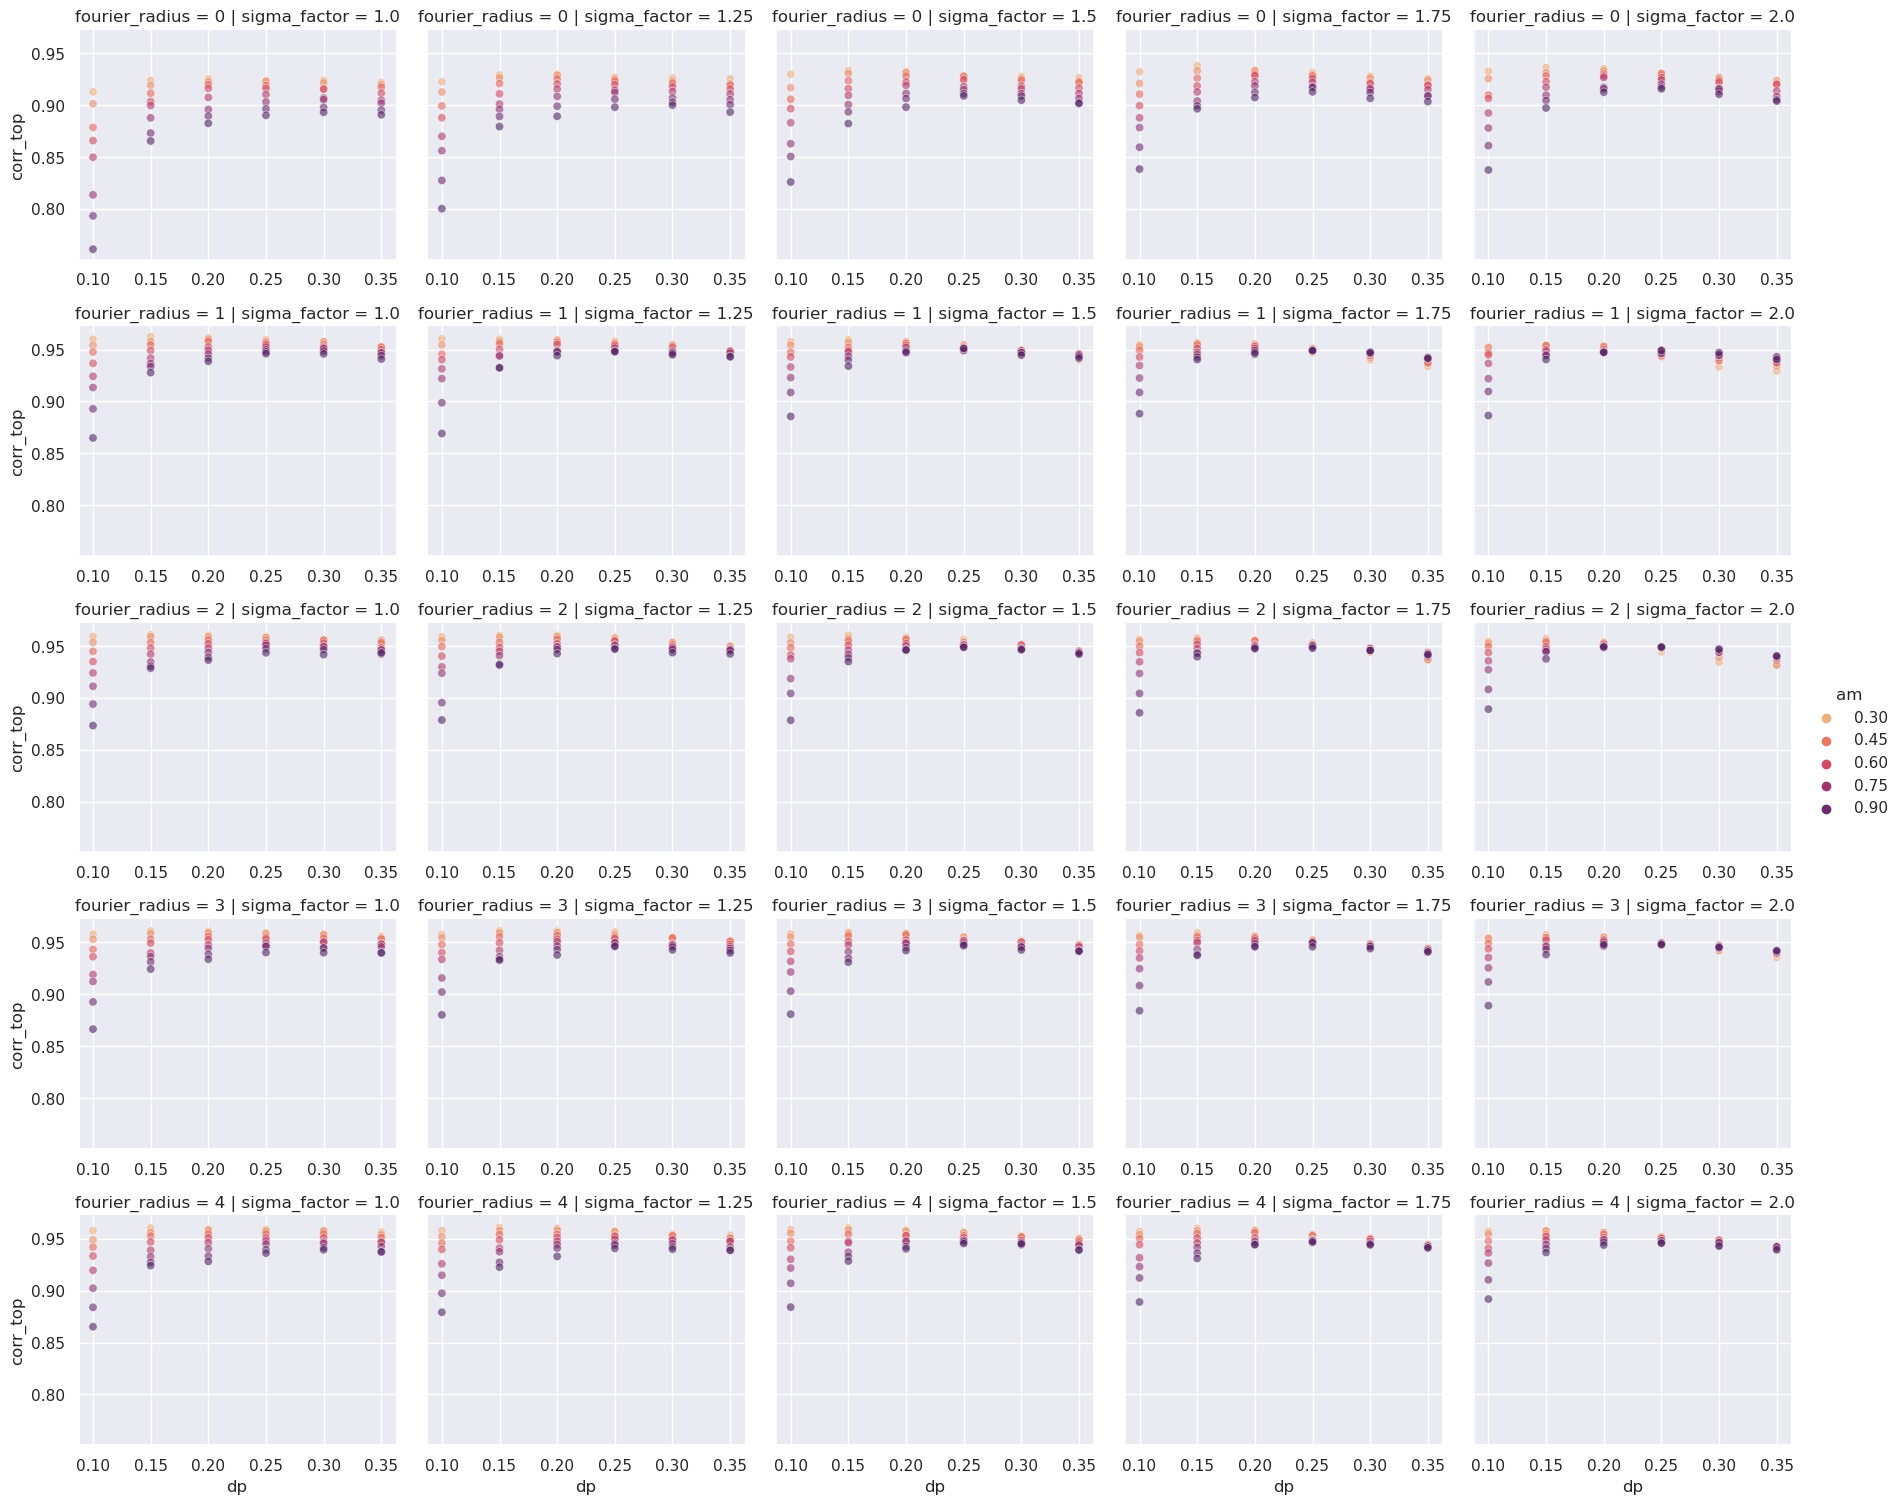

In [129]:
sizes = ((np.arange(1,6)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps ==3'),
    x='dp',
    y='corr_top',
    col='sigma_factor',
    row='fourier_radius',
    alpha=0.6,
    hue='am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

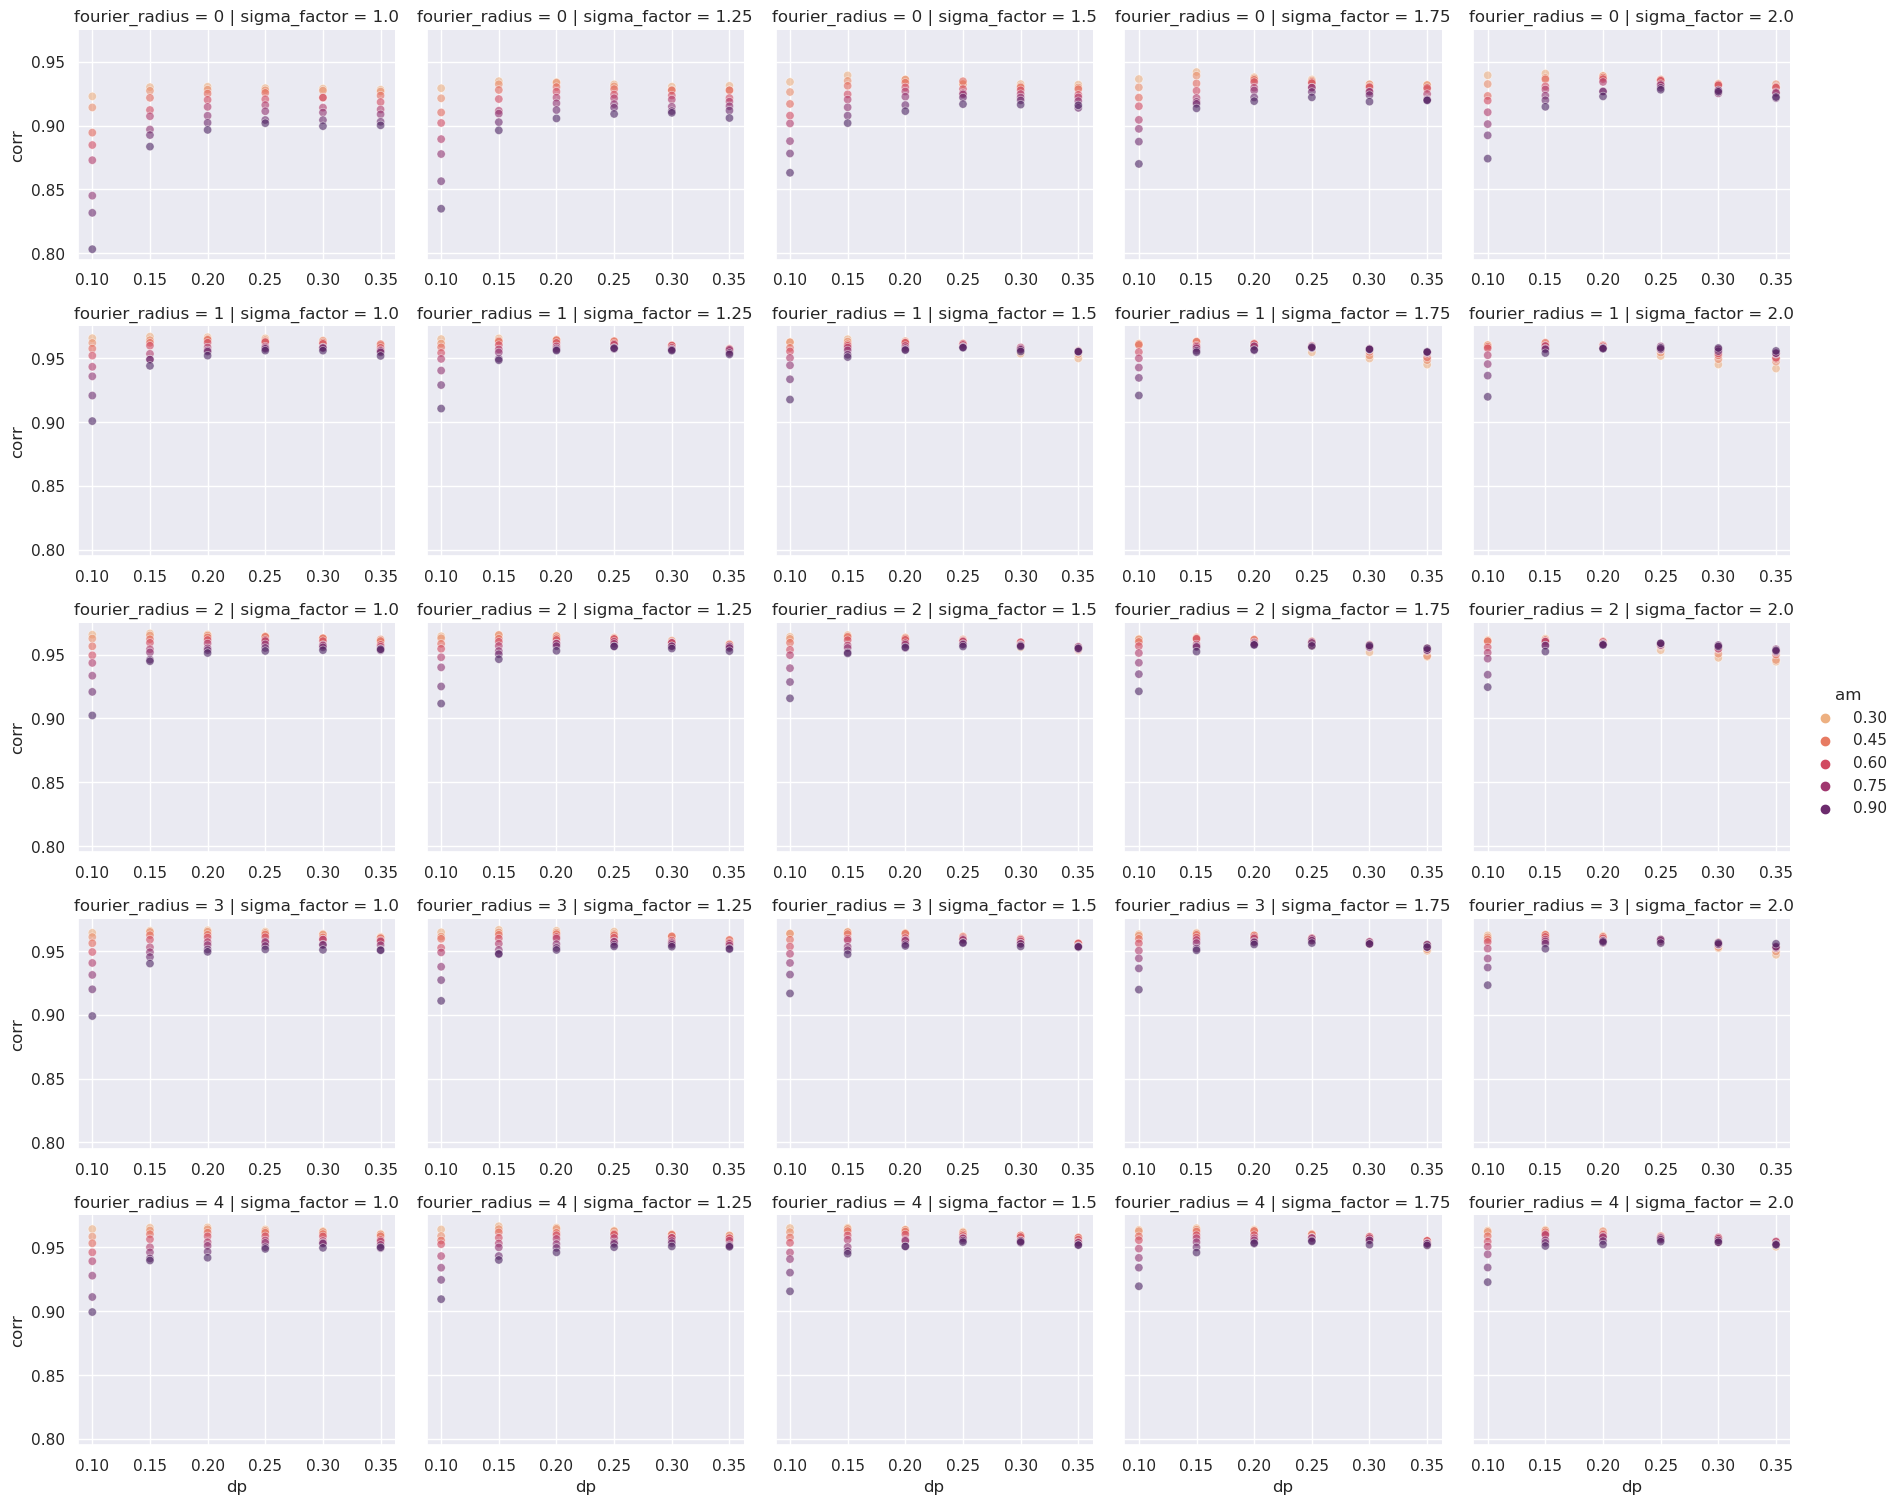

In [142]:
sizes = ((np.arange(1,6)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps ==3'),
    x='dp',
    y='corr',
    col='sigma_factor',
    row='fourier_radius',
    alpha=0.6,
    hue='am',
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

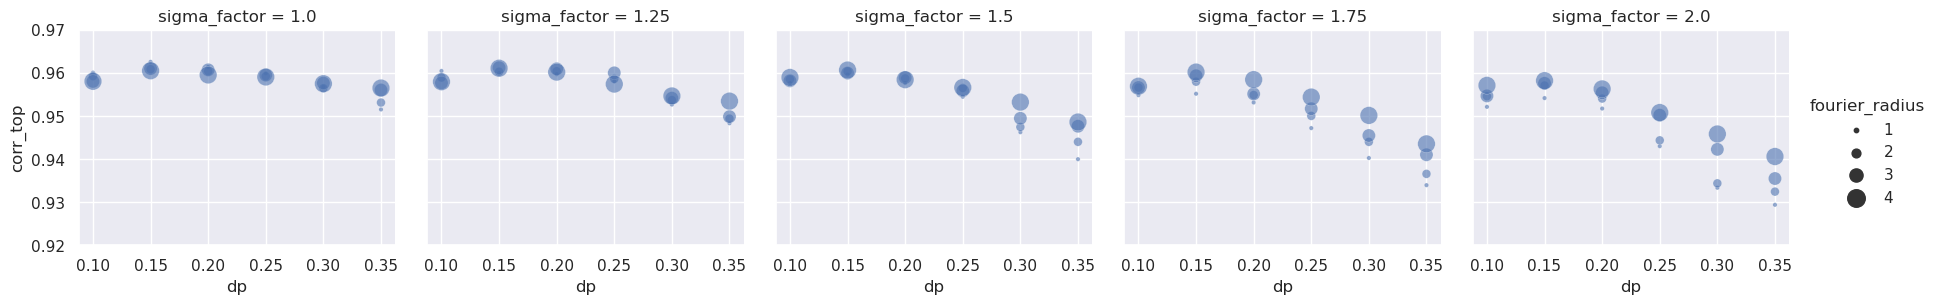

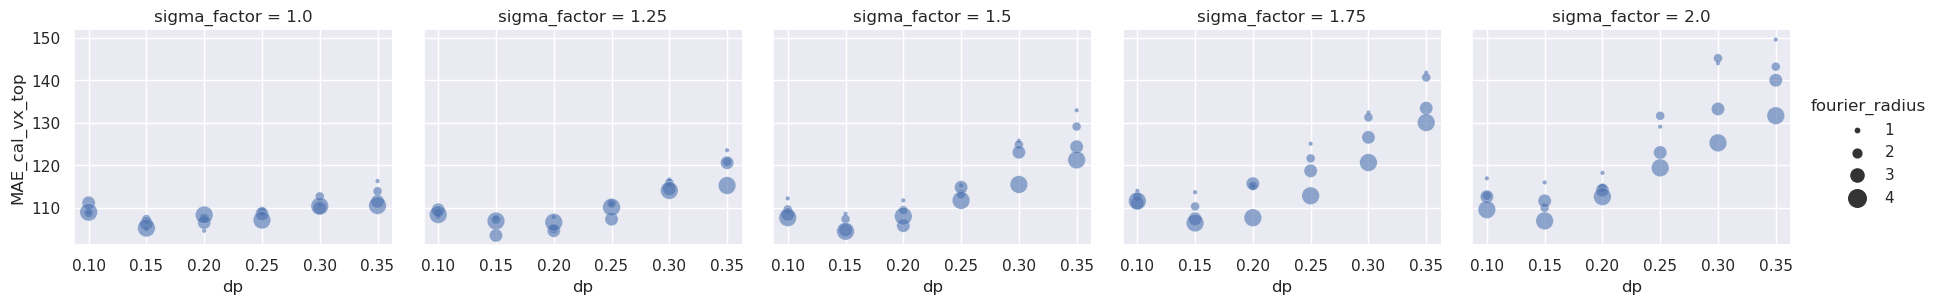

In [169]:
sizes = ((np.arange(1,5)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g1 = sns.relplot(
    data=caldf.query('intsteps ==3 & am == 0.3 & fourier_radius > 0'),
    x='dp',
    y='corr_top',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

g1.set(ylim=(0.92, 0.97))
plt.subplots_adjust(wspace=0.1)

g2 = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3 & fourier_radius > 0'),
    x='dp',
    y='MAE_cal_vx_top',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

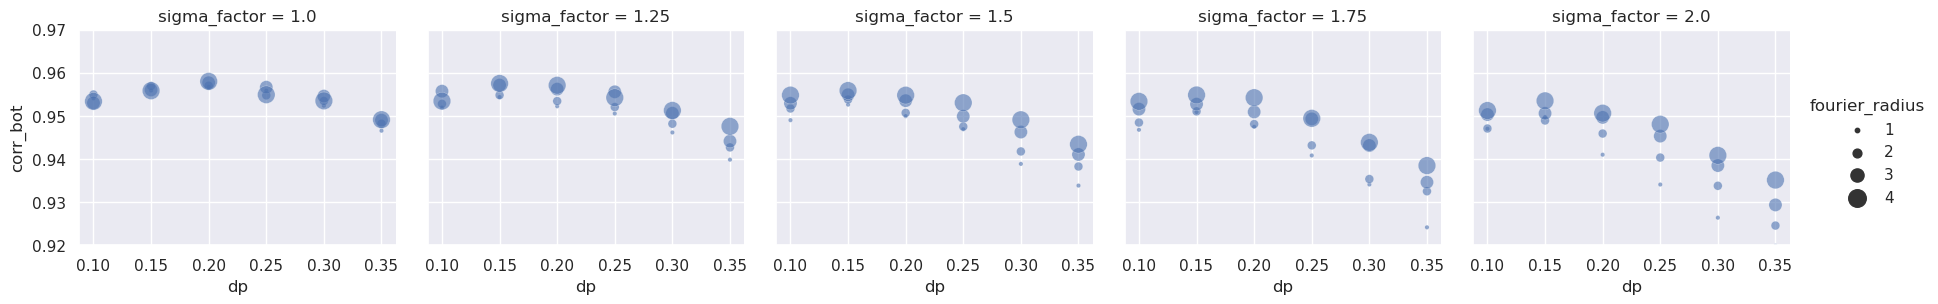

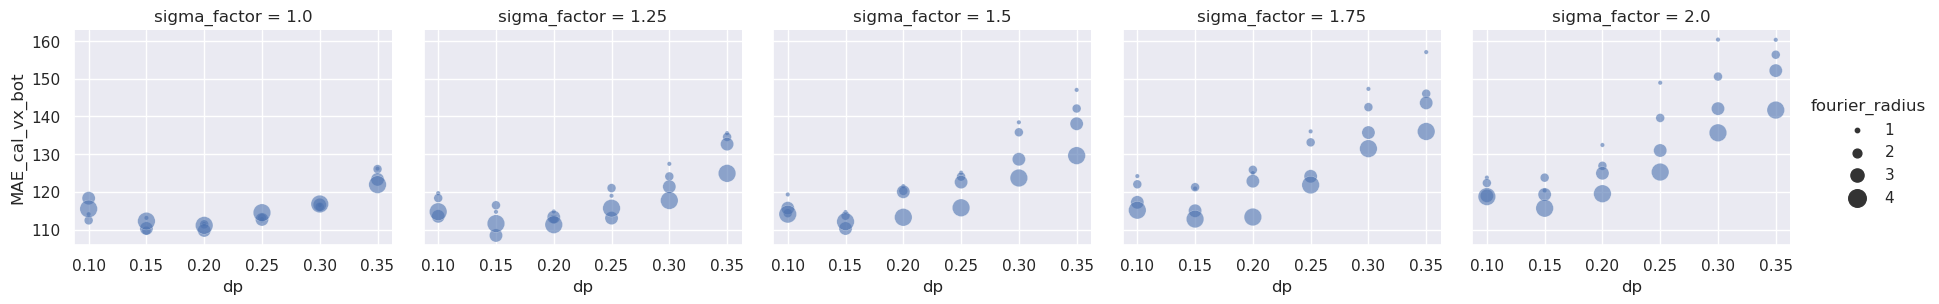

In [171]:
g1 = sns.relplot(
    data=caldf.query('intsteps==3 & am == 0.3 & fourier_radius > 0'),
    x='dp',
    y='corr_bot',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

g1.set(ylim=(0.92, 0.97))
plt.subplots_adjust(wspace=0.1)
plt.show()

g2 = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3 & fourier_radius > 0'),
    x='dp',
    y='MAE_cal_vx_bot',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

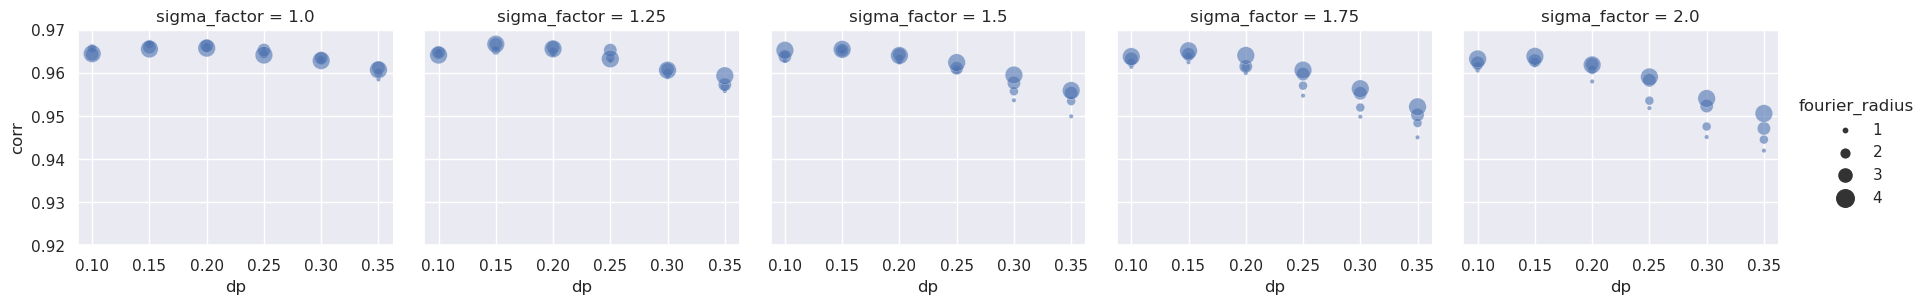

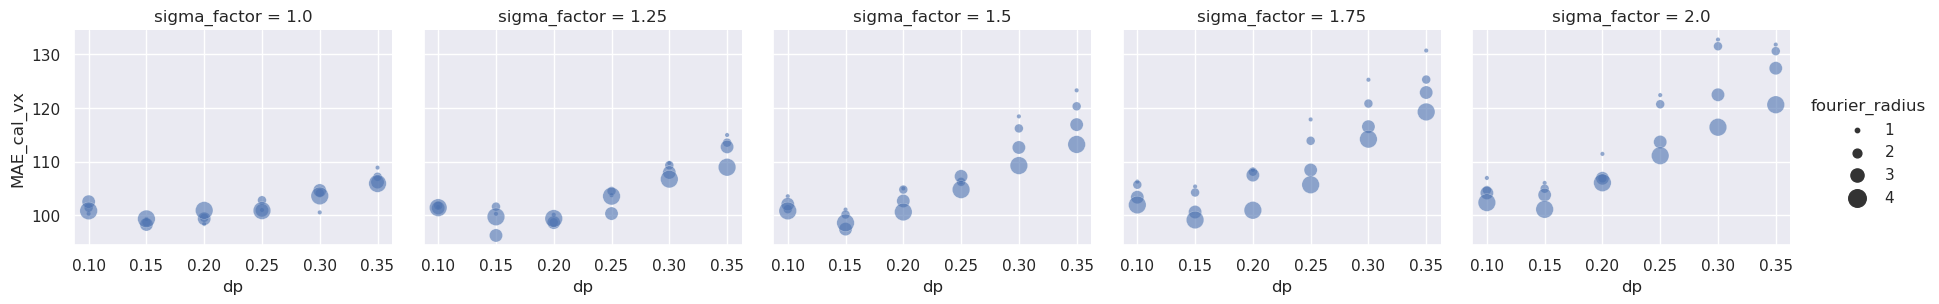

In [172]:
g1 = sns.relplot(
    data=caldf.query('intsteps==3 & am == 0.3 & fourier_radius > 0'),
    x='dp',
    y='corr',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

g1.set(ylim=(0.92, 0.97))
plt.subplots_adjust(wspace=0.1)
plt.show()

g2 = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3 & fourier_radius > 0'),
    x='dp',
    y='MAE_cal_vx',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

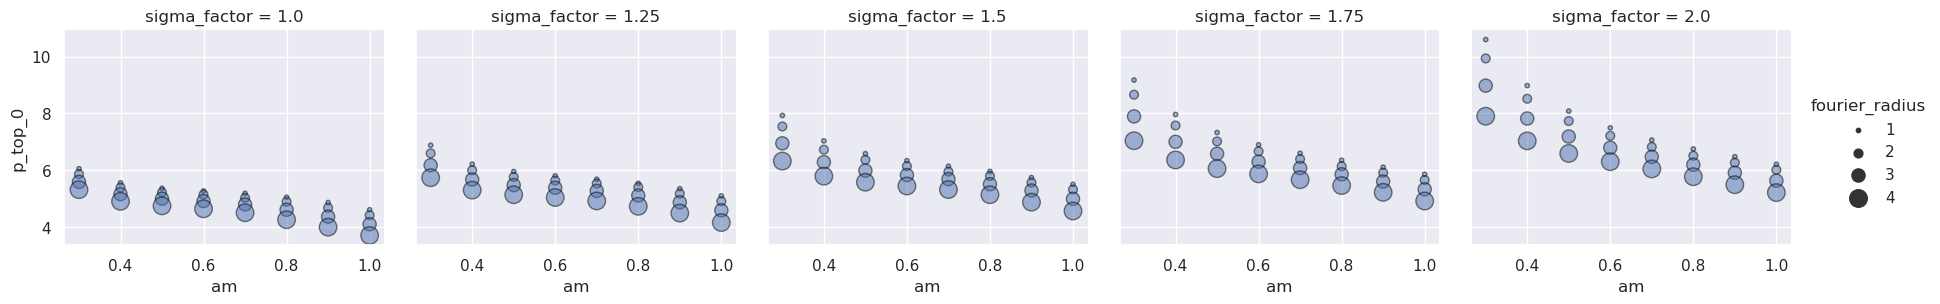

In [159]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & dp == 0.15 & fourier_radius > 0'),
    x='am',
    y='p_top_0',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

In [122]:
caldf.query('intsteps == 3 & am == 0.3 & sigma_factor == 1.0 & fourier_radius > 0')

index  intsteps  ballspacing   am    dp  sigma_factor  fourier_radius  \
1        1         3            1  0.3  0.10           1.0               1   
2        2         3            1  0.3  0.10           1.0               2   
3        3         3            1  0.3  0.10           1.0               3   
4        4         3            1  0.3  0.10           1.0               4   
26      26         3            1  0.3  0.15           1.0               1   
27      27         3            1  0.3  0.15           1.0               2   
28      28         3            1  0.3  0.15           1.0               3   
29      29         3            1  0.3  0.15           1.0               4   
51      51         3            1  0.3  0.20           1.0               1   
52      52         3            1  0.3  0.20           1.0               2   
53      53         3            1  0.3  0.20           1.0               3   
54      54         3            1  0.3  0.20           1.0               4   
76      76         3            1  0.3  0.25           1.0               1   
77      77         3            1  0.3  0.25           1.0               2   
78      78         3            1  0.3  0.25           1.0               3   
79      79         3            1  0.3  0.25           1.0               4   
101    101         3            1  0.3  0.30           1.0               1   
102    102         3            1  0.3  0.30           1.0               2   
103    103         3            1  0.3  0.30           1.0               3   
104    104         3            1  0.3  0.30           1.0               4   
126    126         3            1  0.3  0.35           1.0               1   
127    127         3            1  0.3  0.35           1.0               2   
128    128         3            1  0.3  0.35           1.0               3   
129    129         3            1  0.3  0.35           1.0               4   

     corr_top  corr_bot  MAE_cal_vx_top  MAE_discrep       MAPE       MAPD  \
1    0.960055  0.954099      108.974928    67.309539  15.372926  11.271482   
2    0.959237  0.954984      108.830651    66.558813  15.871259  10.689293   
3    0.958023  0.953026      111.200682    67.686284  15.980173  11.002996   
4    0.958044  0.953389      108.998298    67.989535  15.995259  11.037428   
26   0.962553  0.955917      105.025517    65.047056  15.191770  10.271227   
27   0.960859  0.956964      107.373147    64.153204  15.526042  10.301198   
28   0.960997  0.956036      106.340740    62.689596  15.310936  10.206966   
29   0.960497  0.955856      105.276049    63.016545  15.110188   9.917363   
51   0.961353  0.956751      104.632339    65.159444  15.403672  10.665597   
52   0.960389  0.957020      107.634038    62.564263  15.776852   9.863070   
53   0.960703  0.957717      106.582866    61.314886  15.687142   9.681310   
54   0.959515  0.958027      108.357206    60.975060  14.606740   9.743118   
76   0.959891  0.955864      108.539094    67.378224  15.241486  10.472707   
77   0.959225  0.954782      109.273130    62.248781  15.503694   9.305365   
78   0.959486  0.956674      108.606994    63.384568  15.300523  10.456334   
79   0.959046  0.954938      107.145247    61.675865  15.337384   9.426970   
101  0.956731  0.952381      110.661914    70.253118  14.962998  10.358273   
102  0.956444  0.953477      112.714266    67.463486  15.246067  10.559882   
103  0.957635  0.954605      109.989536    65.377200  15.824149  10.383050   
104  0.957487  0.953514      110.433757    63.528631  15.028818   9.984696   
126  0.951511  0.946573      116.311858    74.469198  16.182336  11.120763   
127  0.953114  0.948192      113.921539    73.144921  15.666563  11.628661   
128  0.956026  0.949032      111.555996    73.134324  15.333228  11.513653   
129  0.956479  0.949137      110.571622    68.036237  16.905792  11.076407   

      p_top_0    p_bot_0  
1    6.495159   8.560860  
2    6.269682   8.158298  
3    5.947756   7.5977

## What about the real-world mean absolute error? 

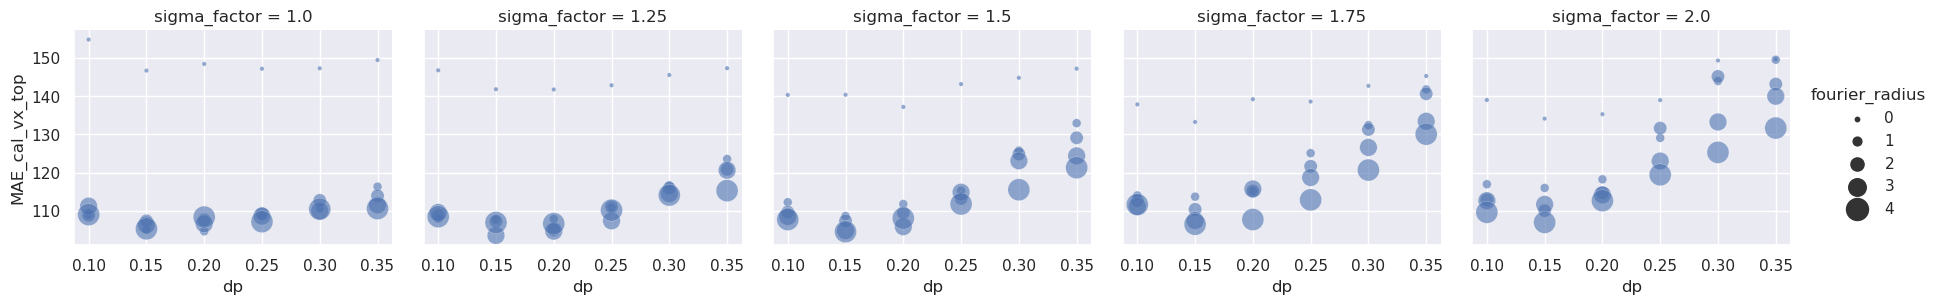

In [168]:
sizes = ((np.arange(1,6)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAE_cal_vx_top',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

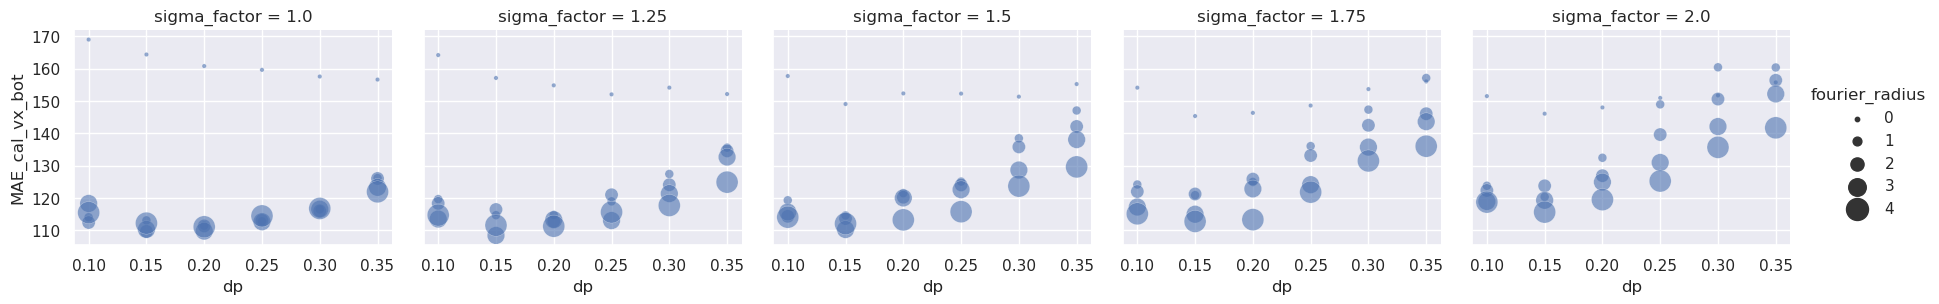

In [165]:
plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAE_cal_vx_bot',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

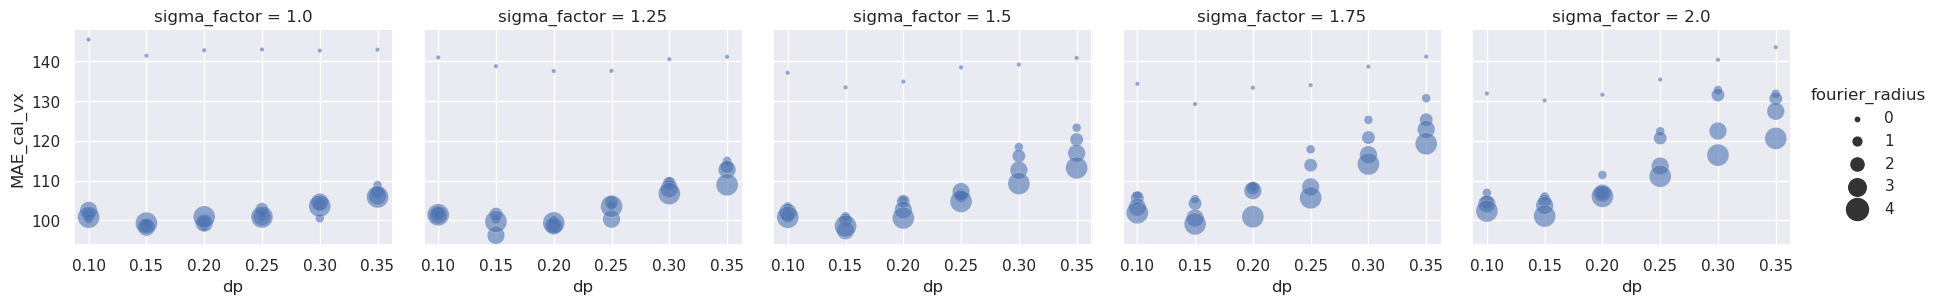

In [150]:
sizes = ((np.arange(1,6)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAE_cal_vx',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

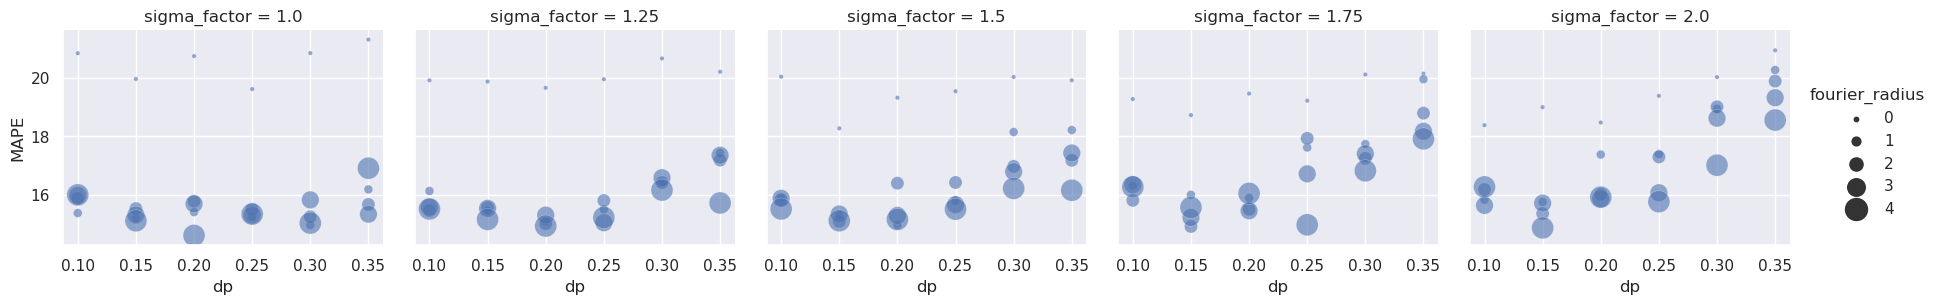

In [102]:
sizes = ((np.arange(1,6)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAPE',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

## What about the discrepancy between top and bottom? 

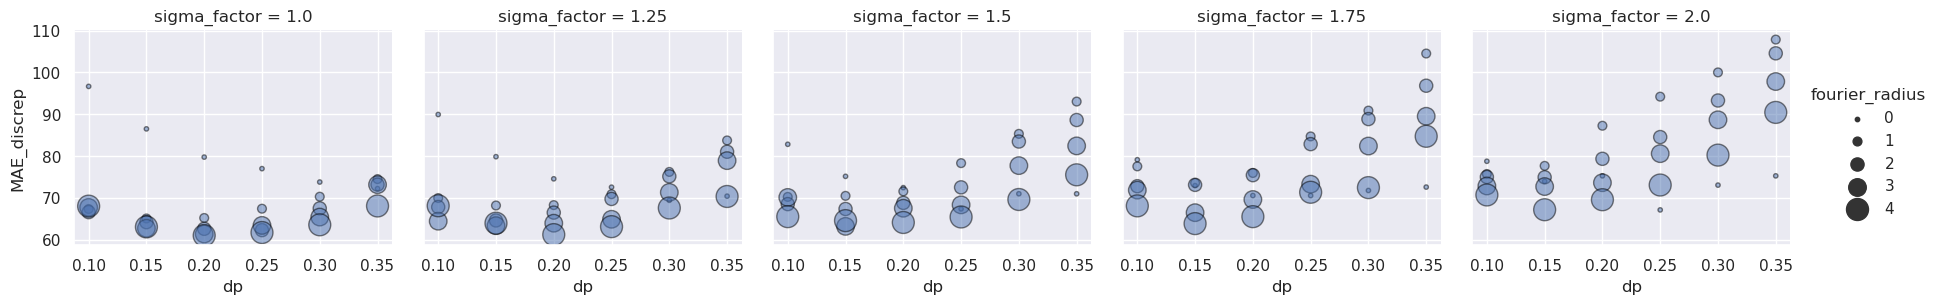

In [119]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAE_discrep',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

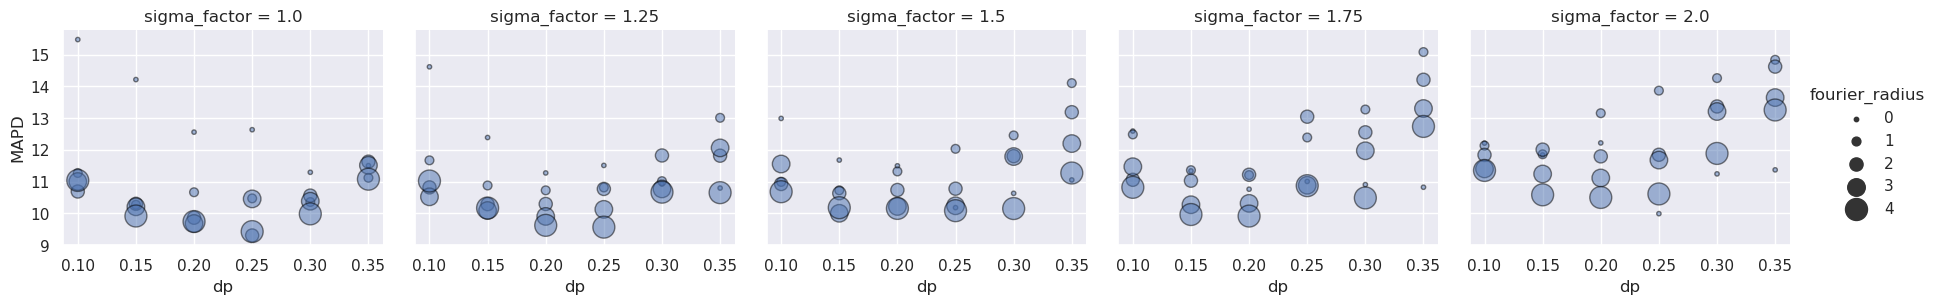

In [137]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAPD',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

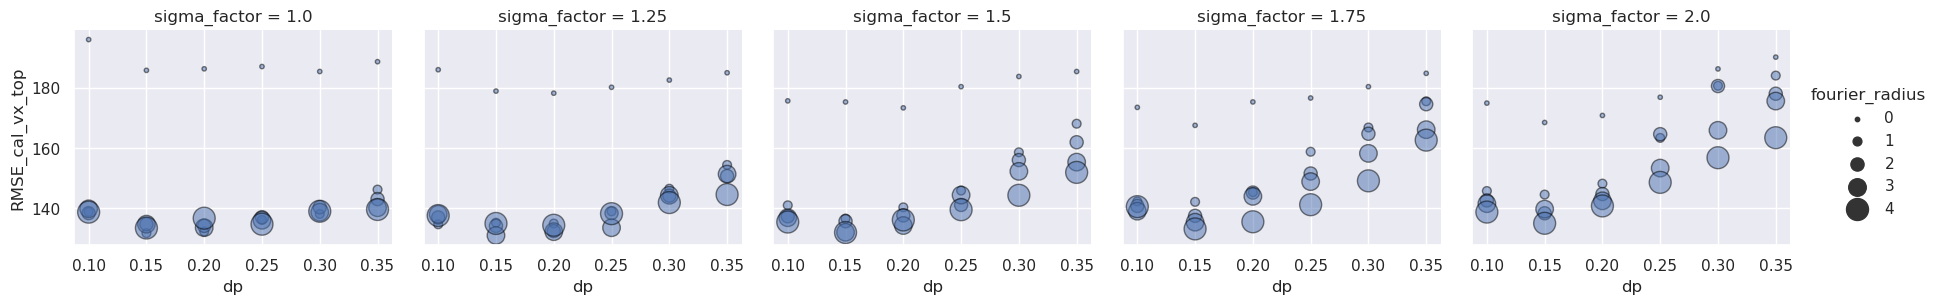

In [136]:
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='RMSE_cal_vx_top',
    col='sigma_factor',
    size='fourier_radius',
    edgecolor='black',
    linewidth=1,
    sizes=sizes,
    alpha=0.5,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

/tmp/ipykernel_8035/2205210438.py:5: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  g = sns.relplot(


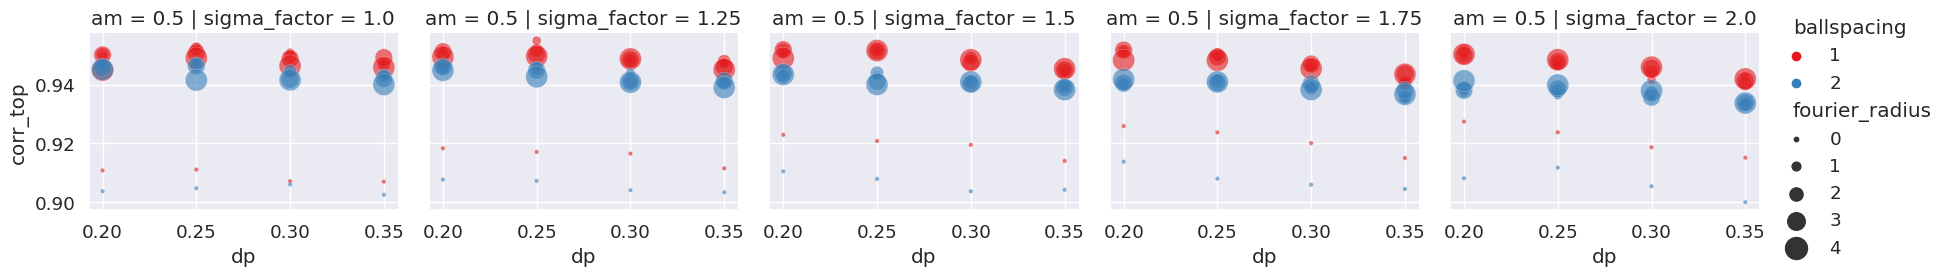

In [53]:
sizes = ((np.arange(1,5)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('intsteps == 3 & am == 0.3'),
    x='dp',
    y='MAE_discrep',
    col='sigma_factor',
    size='fourier_radius',
    sizes=sizes,
    alpha=0.6,
    palette=sns.color_palette("flare", as_cmap=True),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

/tmp/ipykernel_8035/459650985.py:5: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  g = sns.relplot(


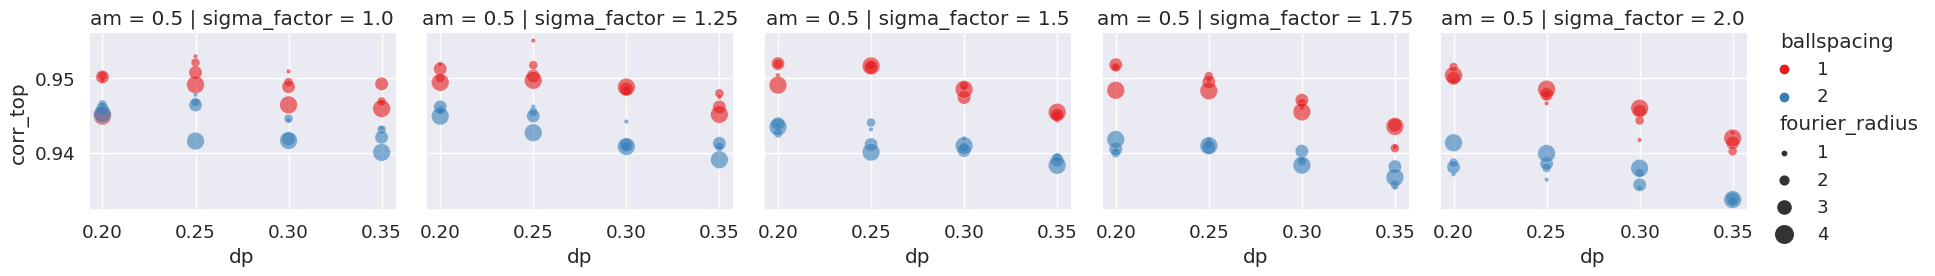

In [44]:
sizes = ((np.arange(1,5)**2)*10).tolist()
plt.close('all')
sns.set_theme()
sns.set(font_scale=1.2) 
g = sns.relplot(
    data=caldf.query('fourier_radius > 0 & intsteps == 4 & am == 0.5'),
    x='dp',
    y='corr_top',
    col='sigma_factor',
    row = 'am',
    size='fourier_radius',
    sizes=sizes,
    hue='ballspacing',
    alpha=0.6,
    palette=sns.color_palette("Set1"),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

/tmp/ipykernel_8035/1440980113.py:5: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  g = sns.relplot(


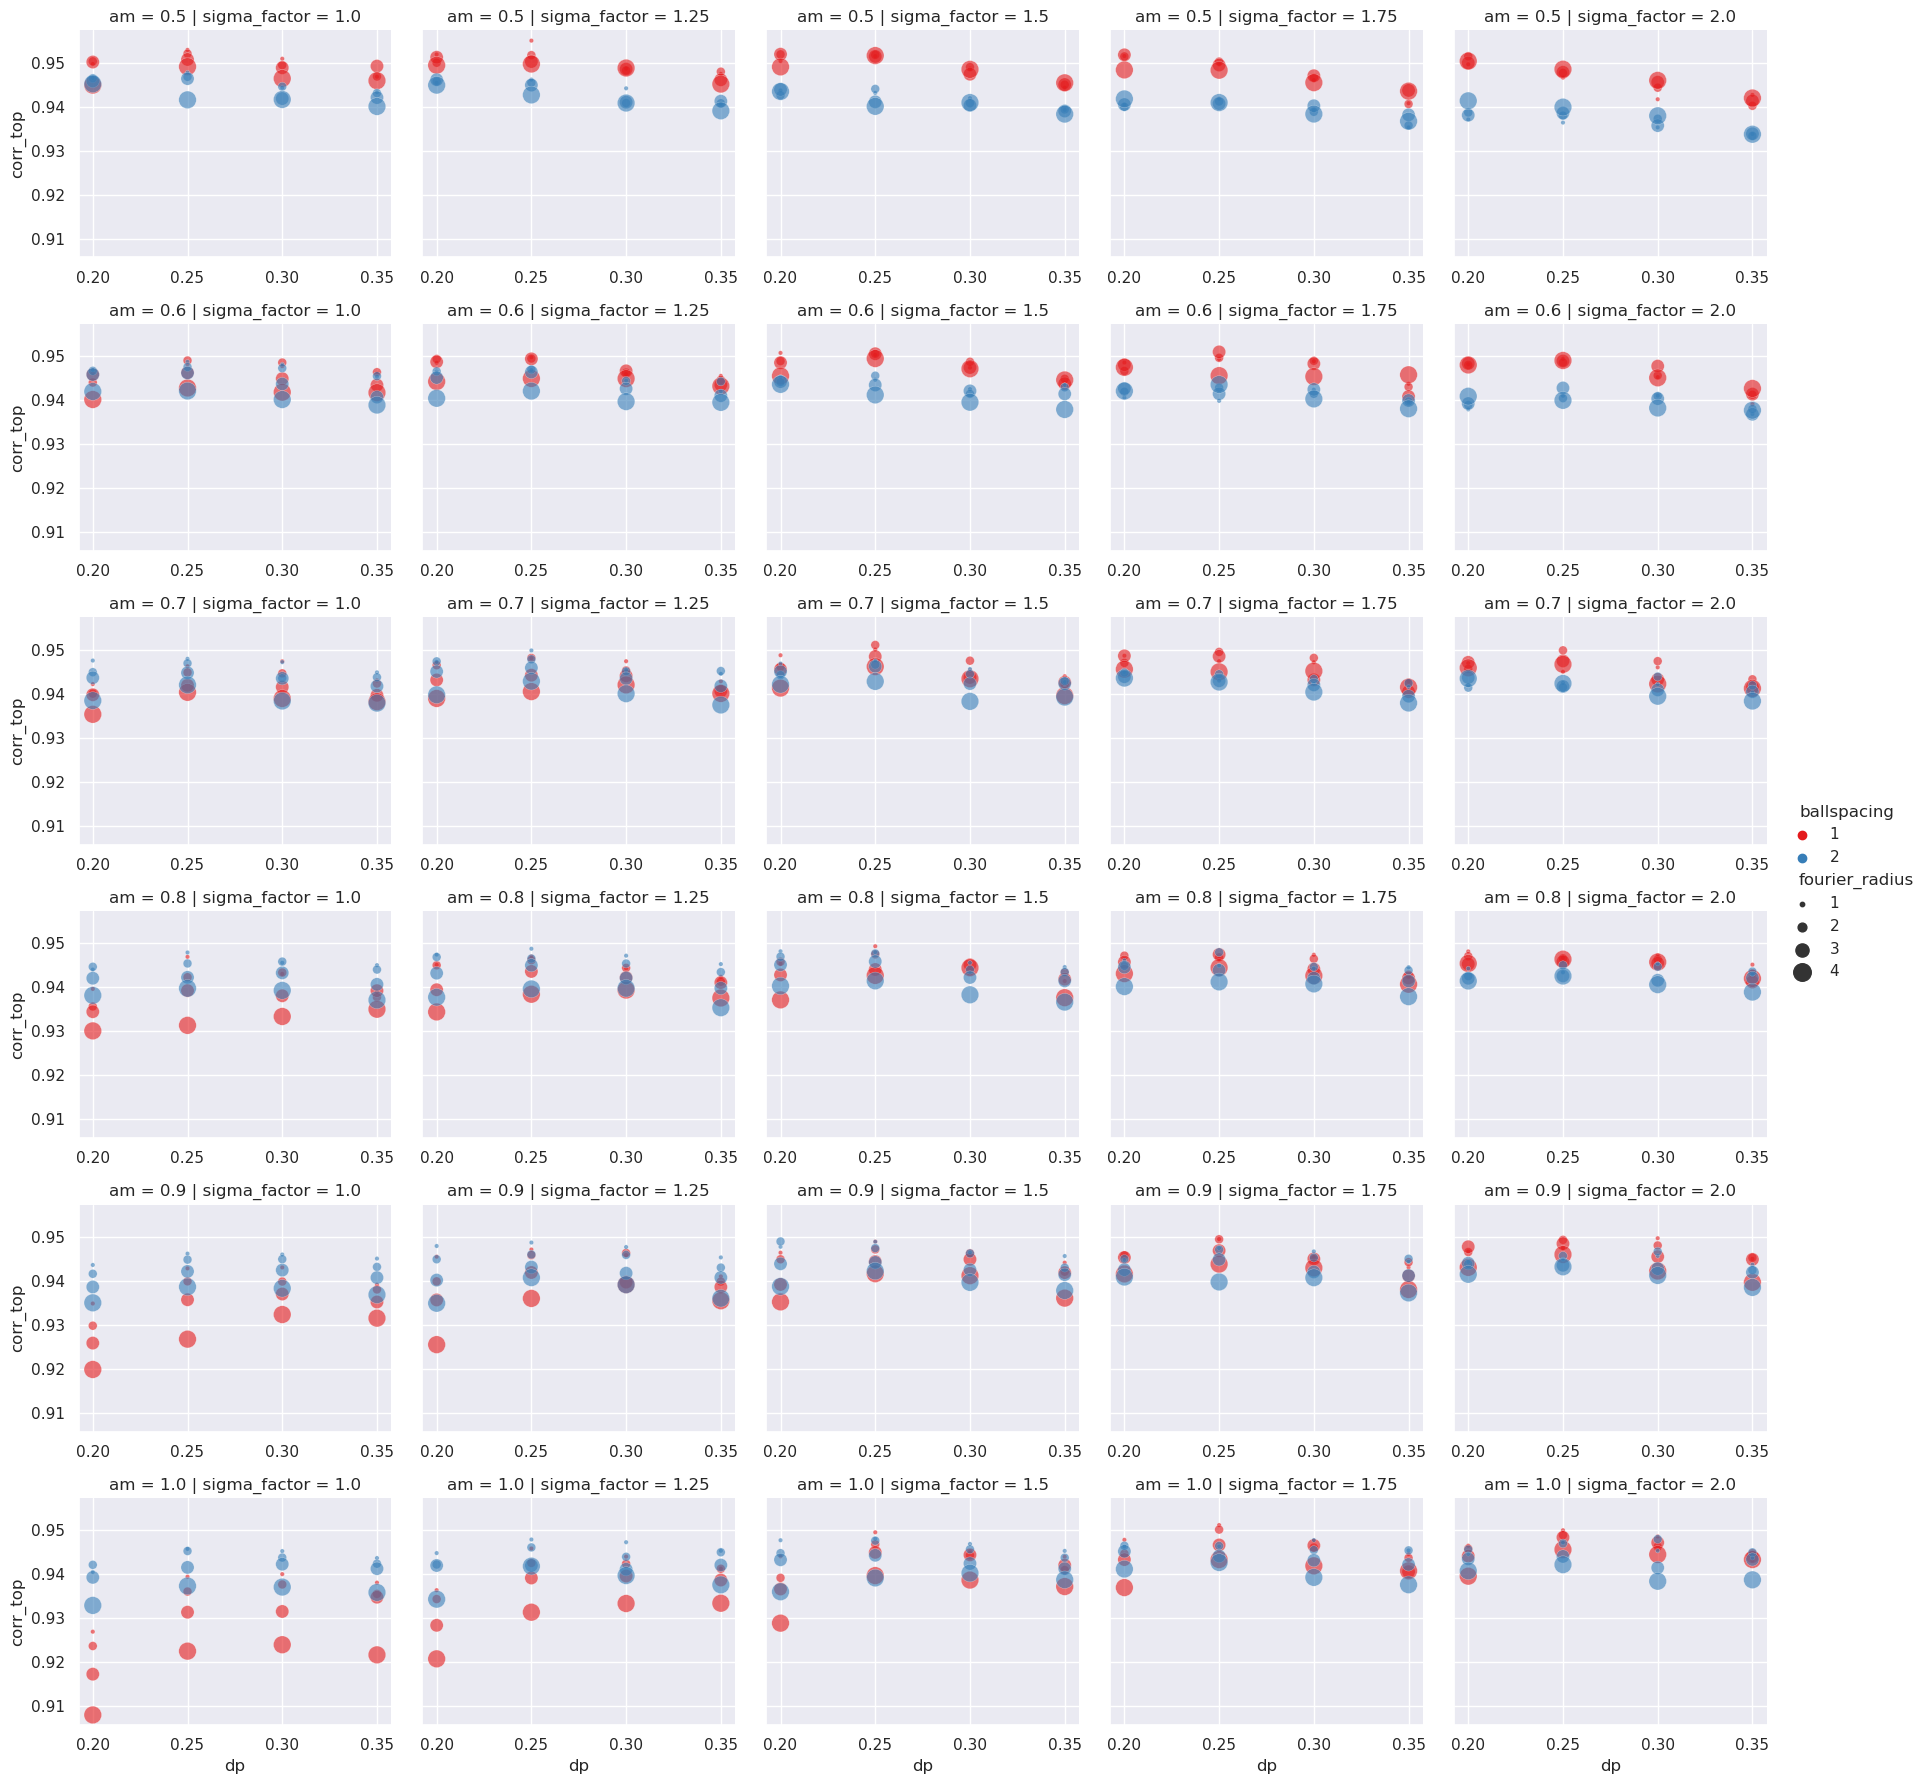

In [29]:
sizes = ((np.arange(1,5)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('fourier_radius > 0 & intsteps == 4'),
    x='dp',
    y='corr_top',
    col='sigma_factor',
    row = 'am',
    size='fourier_radius',
    sizes=sizes,
    hue='ballspacing',
    alpha=0.6,
    palette=sns.color_palette("Set1"),
    height=3, aspect=1.2, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

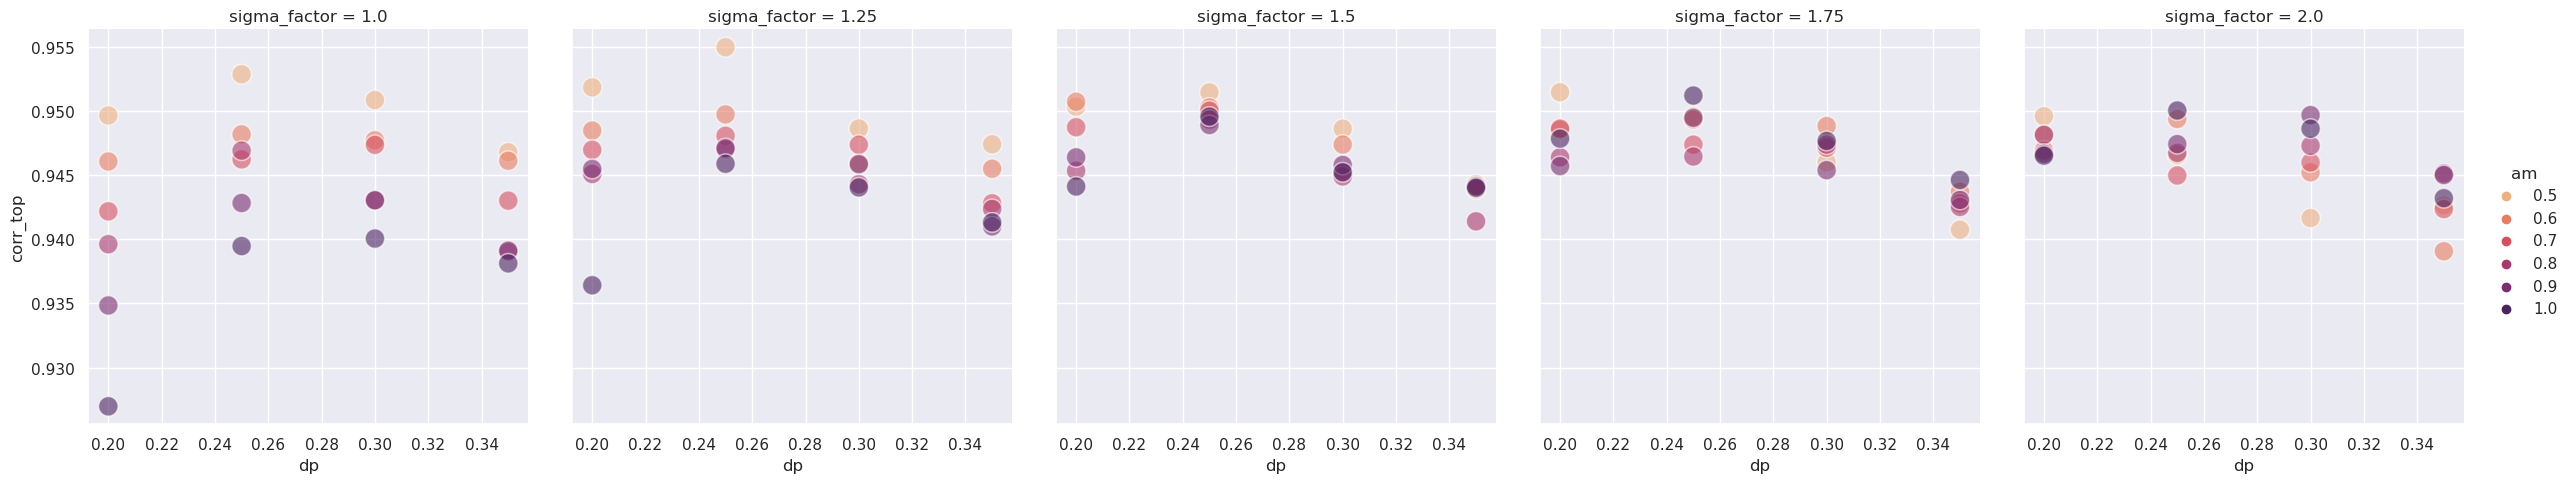

In [30]:
sizes = ((np.arange(1,5)**2)*10).tolist()

plt.close('all')
sns.set_theme()
g = sns.relplot(
    data=caldf.query('fourier_radius > 0 & intsteps == 4 & ballspacing == 1 & fourier_radius == 1'),
    x='dp',
    y='corr_top',
    col='sigma_factor',
    hue='am',
    alpha=0.6,
    s=200,
    palette=sns.color_palette("flare", as_cmap=True),
    height=5, aspect=1, 
    facet_kws={'sharex':False, 'legend_out':True}
)

plt.subplots_adjust(wspace=0.1)
plt.show()

In [31]:
caldf.query('fourier_radius > 0 & intsteps == 4 & ballspacing == 1 & fourier_radius == 1 & sigma_factor == 2')[['am', 'dp', 'corr_top']].head()

am    dp  corr_top
21   0.5  0.20  0.949607
46   0.5  0.25  0.946582
71   0.5  0.30  0.941664
96   0.5  0.35  0.942657
121  0.6  0.20  0.948148

dp       0.20      0.25      0.30      0.35
am                                         
0.5  0.949607  0.946582  0.941664  0.942657
0.6  0.948148  0.949391  0.945232  0.939076
0.7  0.946931  0.944985  0.946000  0.942367
0.8  0.948156  0.946747  0.947302  0.945141
0.9  0.946675  0.947429  0.949693  0.945019


<AxesSubplot: xlabel='dp', ylabel='am'>

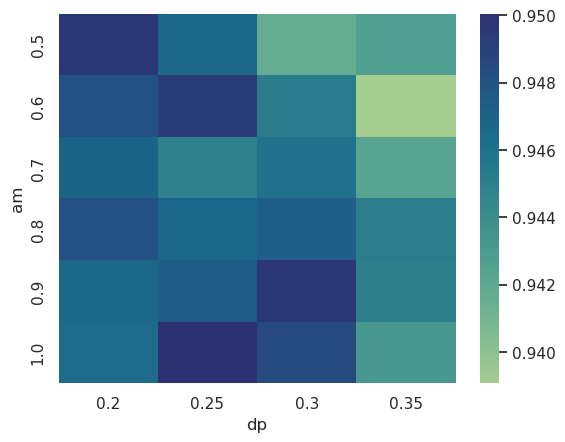

In [32]:
pt = caldf.query('fourier_radius > 0 & intsteps == 4 & ballspacing == 1 & fourier_radius == 1 & sigma_factor == 2')[['am', 'dp', 'corr_top']].pivot(index='am', columns='dp', values= 'corr_top')
print(pt.head())
sns.heatmap(pt, cmap='crest')

In [33]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    heatmap_data = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(heatmap_data, **kwargs)
    ax.invert_yaxis()

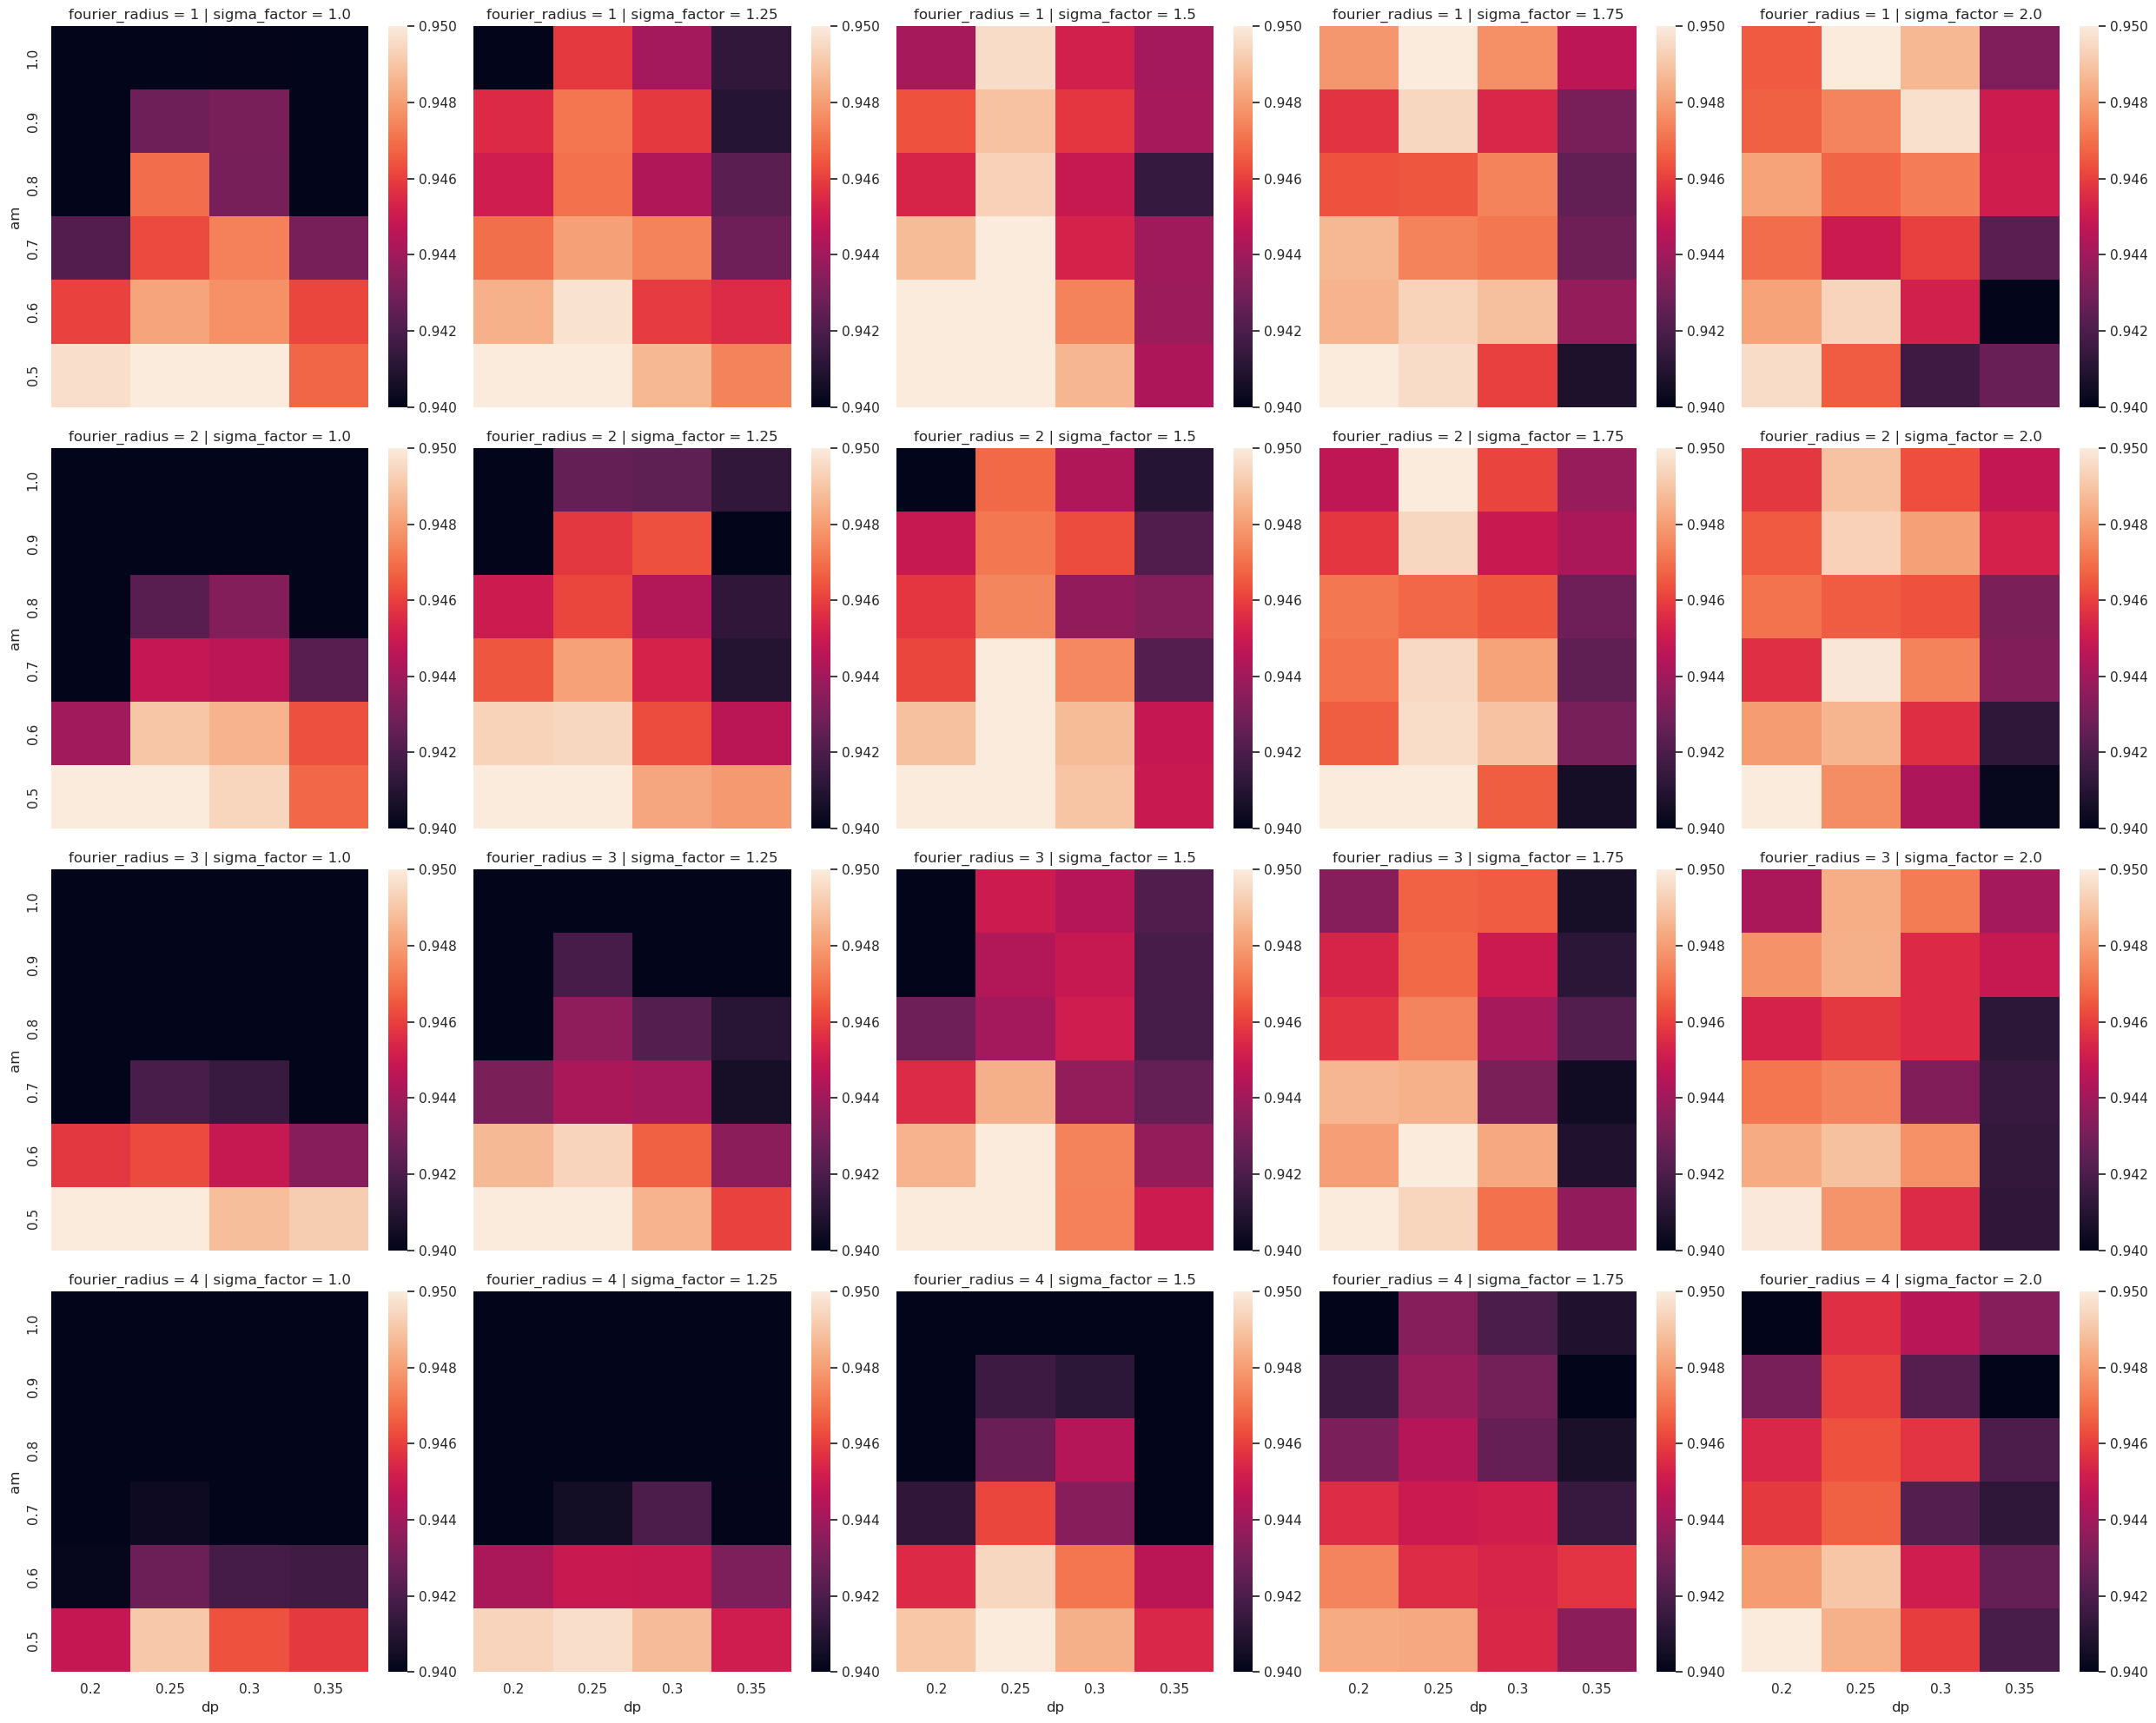

In [39]:
sns.set(font_scale=1) 
data = caldf.query('fourier_radius > 0 & intsteps == 4 & ballspacing == 1')
fg = sns.FacetGrid(data, col='sigma_factor', row='fourier_radius', height=5, aspect=1)
fg.map_dataframe(draw_heatmap, 'dp', 'am', 'corr_top', vmin=0.94, vmax=0.95, cbar=True)

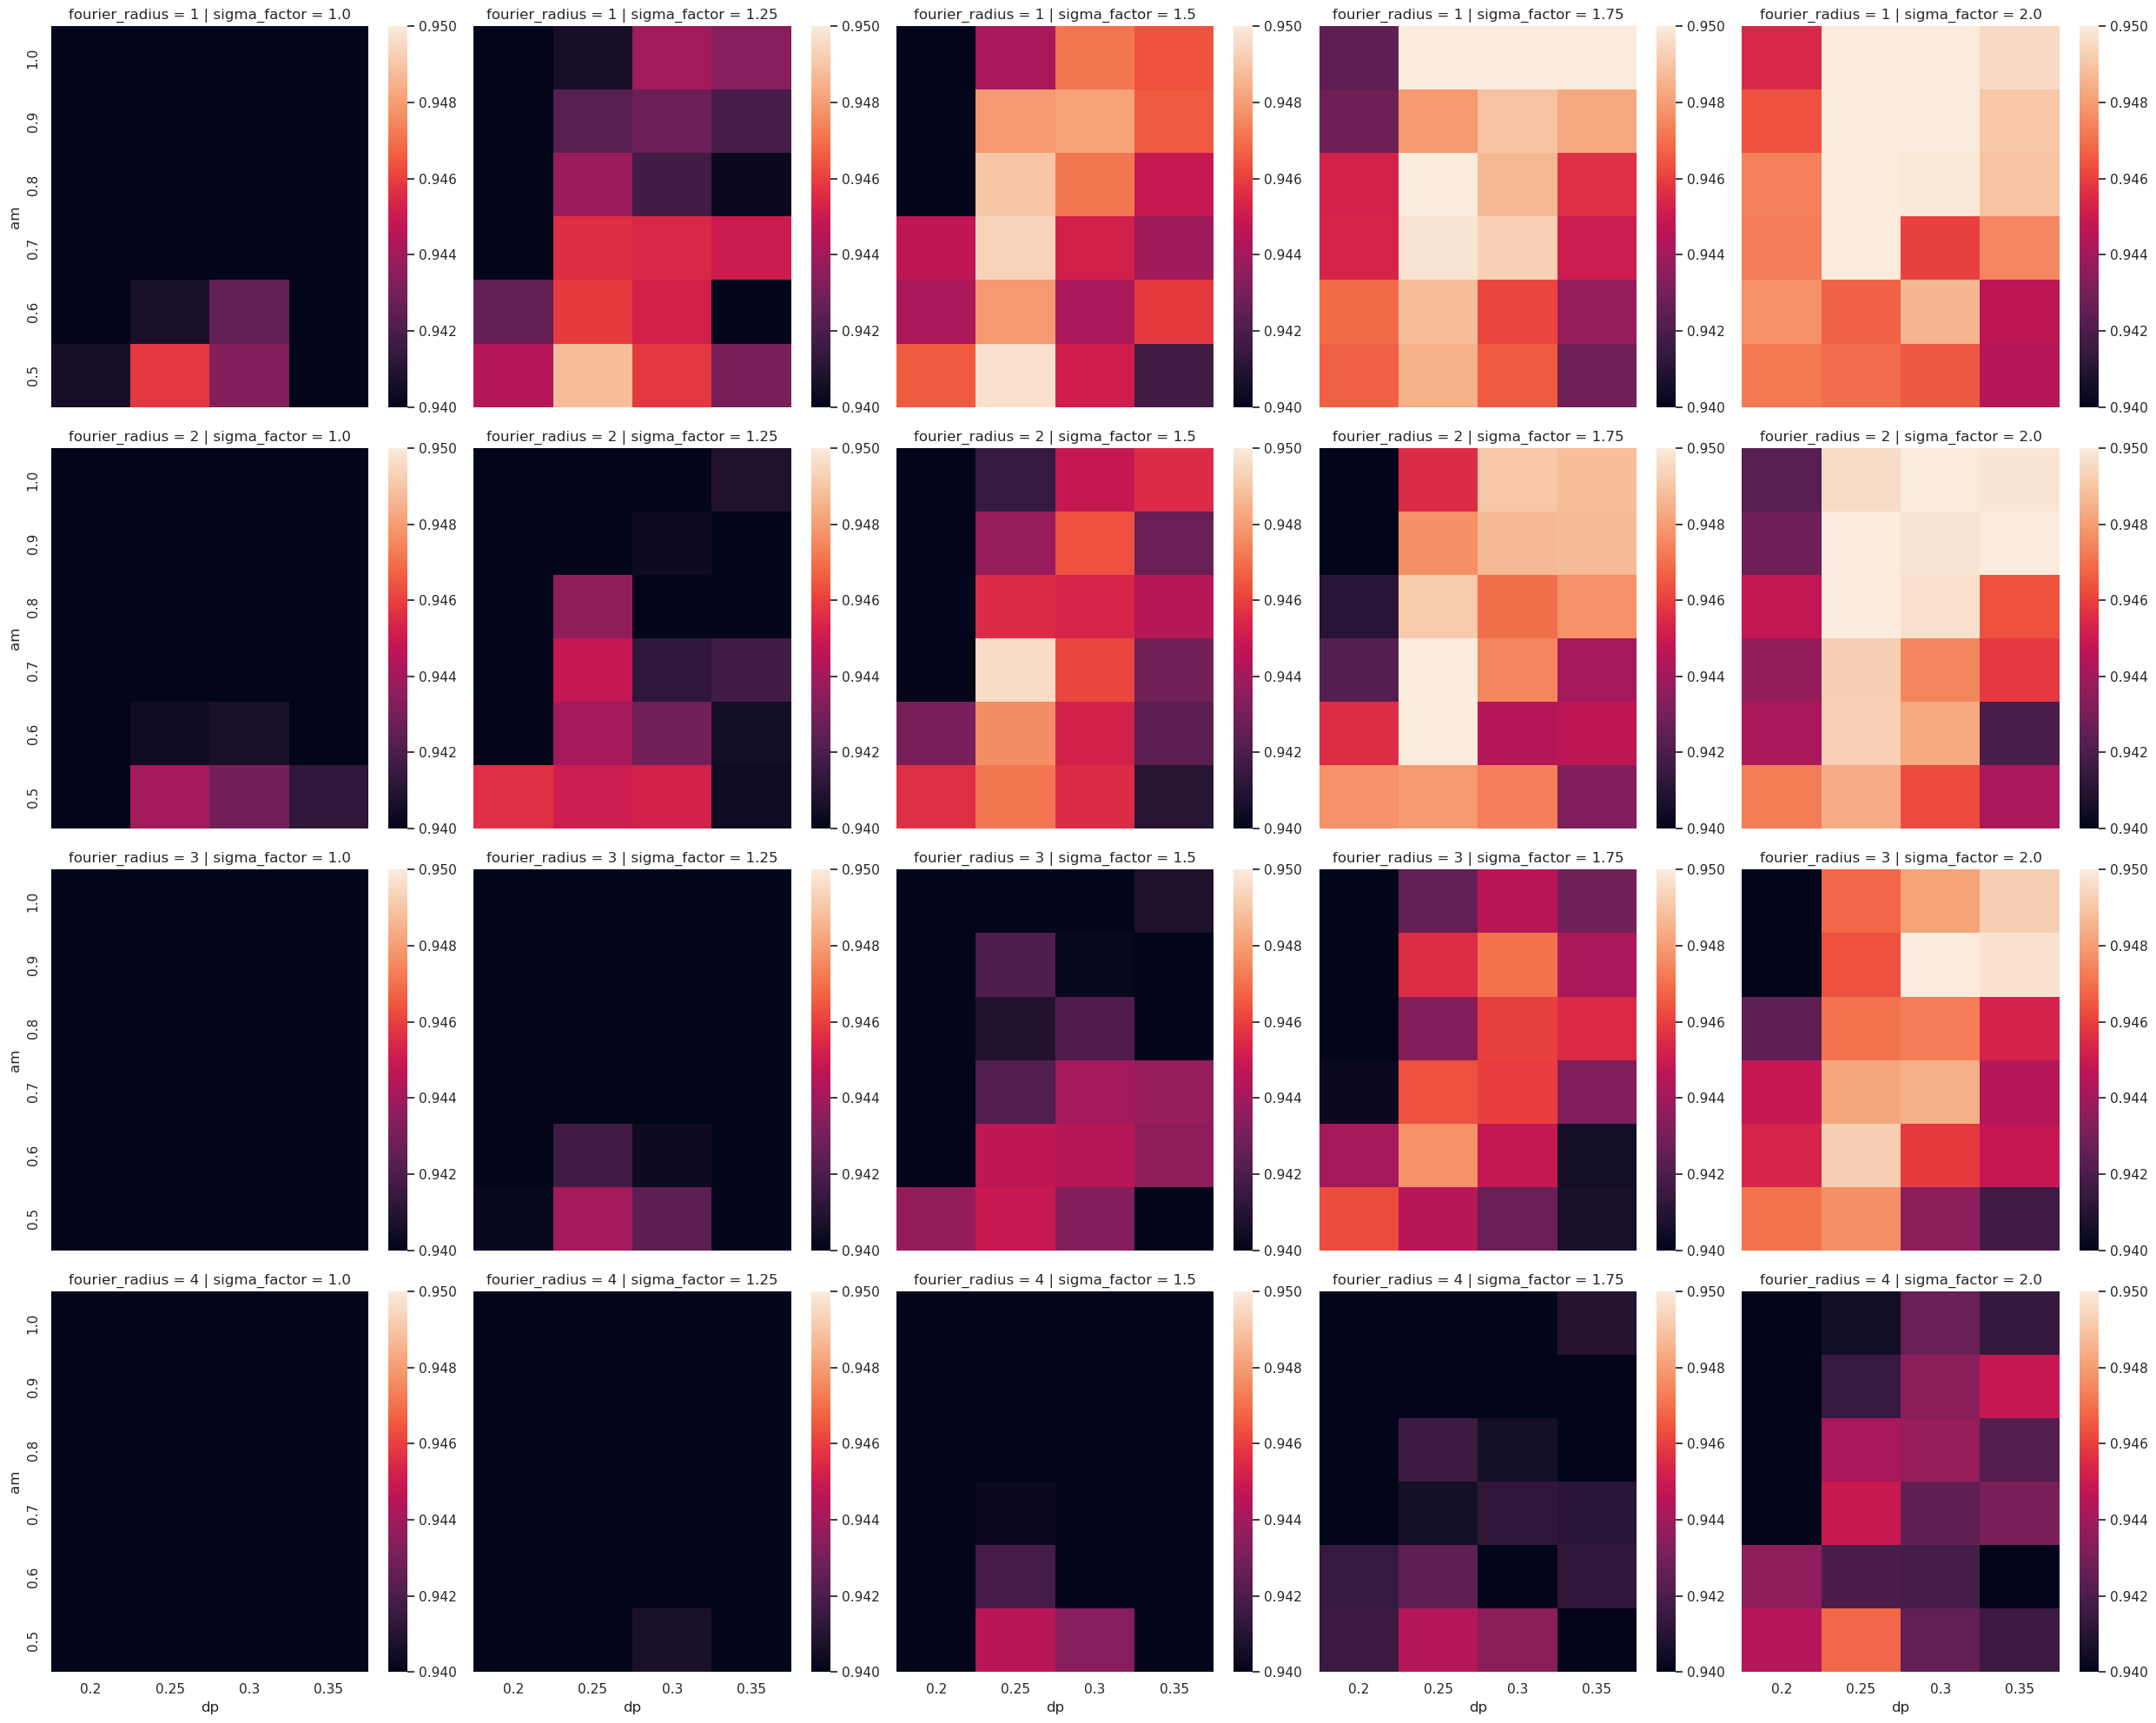

In [129]:
data = caldf.query('fourier_radius > 0 & intsteps == 6 & ballspacing == 1')
fg = sns.FacetGrid(data, col='sigma_factor', row='fourier_radius', height=5, aspect=1)
fg.map_dataframe(draw_heatmap, 'dp', 'am', 'corr_top', vmin=0.94, vmax=0.95, cbar=True)

In [75]:
df.pivot("Model", "Task", "Score")

/tmp/ipykernel_1388/3650951129.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df.pivot("Model", "Task", "Score")


Task         CoLA  MNLI  MRPC  QNLI   QQP   RTE  SST-2  STS-B
Model                                                        
BERT         60.5  86.7  89.3  92.7  72.1  70.1   94.9   87.6
BiLSTM       11.6  65.6  81.8  74.6  62.5  57.4   82.8   70.3
BiLSTM+Attn  18.6  67.6  83.9  74.3  60.1  58.4   83.0   72.8
BiLSTM+CoVe  18.5  65.4  78.7  70.8  60.6  52.7   81.9   64.4
BiLSTM+ELMo  32.1  67.2  84.7  75.5  61.1  57.4   89.3   70.3
ERNIE        75.5  92.3  93.9  97.3  75.2  92.6   97.8   93.0
RoBERTa      67.8  90.8  92.3  95.4  74.3  88.2   96.7   92.2
T5           71.6  92.2  92.8  96.9  75.1  92.8   97.5   93.1

In [45]:
# unit in m/s for Stein simulation for 1 px / frame interval
u = 368000 / 60
trange = [0, 60]
fwhm = 7
trim = 10 # Same as Benoit
fov = np.s_[trim:-trim:fwhm, trim:-trim:fwhm]
# Get Stein velocity
datadir_stein = os.path.join(os.environ['DATA'], 'Ben/SteinSDO/')
svx_files = sorted(glob.glob(os.path.join(datadir_stein, 'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir_stein, 'SDO_vy*.fits')))
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)

In [46]:
vx_stein[fov].shape

(35, 35)

In [48]:
35*35

1225

In [ ]:
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel=ker)
v_stein = np.sqrt(vx_stein_sm ** 2 + vy_stein_sm ** 2)
print(v_stein.shape)

In [ ]:
# List of balltracked velocity flows. Sorting the list is essential, so that the index in the list match the
# index of the filename. Later, we will enumerate the for loop to get the index, instead of fetching
# the index stored in the filename. It is the same index that indexes the dataframe in correlation_dataframe_boxcar_gaussian.csv
datadir = os.path.join(os.environ['DATA'], 'sanity_check', 'stein_series', 'calibration2')
filelist = sorted(glob.glob(os.path.join(datadir, 'mean_velocity*.npz')))
print(len(filelist))
# Get the filename and calibration coefficient at the each index of the selected top and bottom velocities
vel_top = [[filelist[idx], dftop.loc[idx, 'p_top_0']] for idx in dftop.index]
vel_bot = [[filelist[idx], dfbot.loc[idx, 'p_bot_0']] for idx in dfbot.index]
print(len(vel_top), len(vel_bot))

In [ ]:
vx_top_cal = []
vy_top_cal = []
vx_bot_cal = []
vy_bot_cal = []

for i, v in enumerate(vel_top):
    with np.load(v[0]) as vel:
        idx = dftop.index[i]
        vx_top_cal.append(vel['vx_top'].astype(np.float32) * v[1] * u)
        vy_top_cal.append(vel['vy_top'].astype(np.float32) *v[1] * u)
for i, v in enumerate(vel_bot):
    with np.load(v[0]) as vel:
        idx = dfbot.index[i]
        vx_bot_cal.append(vel['vx_bot'].astype(np.float32) * v[1] * u)
        vy_bot_cal.append(vel['vy_bot'].astype(np.float32) * v[1] * u)

In [ ]:
%%time
ntop = len(vel_top)
nbot = len(vel_bot)
corr_cal = np.zeros([ntop, nbot])
mape = np.zeros([ntop, nbot])
for i in range(ntop):
    for j in range(nbot):
        vxc = 0.5 * (vx_top_cal[i] + vx_bot_cal[j])
        vyc = 0.5 * (vy_top_cal[i] + vy_bot_cal[j])
        v_cal = np.sqrt(vxc** 2 + vyc** 2)
        corr_cal[i, j] = calc_c_pearson(vx_stein_sm, vxc, vy_stein_sm, vyc, fov=fov)
        mape[i, j] = np.median(np.abs((v_stein - v_cal)[fov] / v_stein[fov]).ravel())*100

In [ ]:
corr_cal.max(), mape.min()

In [ ]:
# MAPE for the maximum correlation
print(mape.ravel()[np.argmax(corr_cal)])
# Correlation for the minimum MAPE
print(corr_cal.ravel()[np.argmin(mape)])

In [ ]:
vx_top_avg = np.array(vx_top_cal).mean(axis=0)
vy_top_avg = np.array(vy_top_cal).mean(axis=0)
vx_bot_avg = np.array(vx_bot_cal).mean(axis=0)
vy_bot_avg = np.array(vy_bot_cal).mean(axis=0)

In [ ]:
vx_avg = (vx_top_avg + vx_bot_avg)/2
vy_avg = (vy_top_avg + vy_bot_avg)/2
v_avg = np.sqrt(vx_avg** 2 + vy_avg** 2)
corr_avg = calc_c_pearson(vx_stein_sm, vx_avg, vy_stein_sm, vy_avg, fov=fov)
mape_avg = np.median(np.abs((v_stein - v_avg) / v_stein)[fov].ravel())*100
print(corr_avg)
print(mape_avg)

In [ ]:
v_avg2.min()

In [ ]:
corr_max_ind = np.unravel_index(np.argmax(corr_cal, axis=None), corr_cal.shape)
mape_min_ind = np.unravel_index(np.argmin(mape, axis=None), mape.shape)
print(corr_max_ind)
print(mape_min_ind)
print(dftop.index[corr_max_ind[0]])
dftop.loc[[
    dftop.index[corr_max_ind[0]],
    dftop.index[mape_min_ind[0]]]][cols]

In [ ]:
dfbot.loc[[
    dfbot.index[corr_max_ind[1]],
    dfbot.index[mape_min_ind[1]]]][cols]

Run Balltracking with these optimized parameters in `balltracking_scripts/stein_balltrack2.py`

Gaussian - based on best top/bot correlations from cross-calibration:
- best top-tracking: rs=2, ballspacing =2 intsteps = 5, am=1.0, dp=0.25, sigma_factor=1.5, fourier_radius = 1 - Calibration factor = 1.791657
- best bottom-tracking: rs=2, ballspacing =2 intsteps = 5, am=1.0, dp=0.25, sigma_factor=2.0, fourier_radius = 2 - Calibration factor = 1.761954

In [ ]:
a = np.zeros([10, 10])
a[(2,4)]

In [ ]:
mape_up.min()